In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image,ImageDraw
import random

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image,ImageDraw
import random
import math
import cv2
import skimage.exposure
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm

In [2]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image,ImageDraw
import random
import math
import cv2
import skimage.exposure
import torchvision.models as models
from tqdm import tqdm
import torch.nn as nn
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
import joblib
#import comet_ml
#from comet_ml import Experiment
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, random_split
import torch.nn.functional as F

# Sprawdzenie spojnosci jpg i csv

In [16]:
import os
import pandas as pd

def validate_csv(csv_file, root_dir, output_csv):
    """
    Validate the CSV file by checking if the files exist in the dataset directory.
    Remove missing files and save a new CSV file.
    
    Args:
    - csv_file (str): Path to the input CSV file.
    - root_dir (str): Path to the dataset directory containing the images.
    - output_csv (str): Path to save the validated CSV file.
    """
    df = pd.read_csv(csv_file)
    
    valid_rows = []
    
    for idx, row in df.iterrows():

        img_path = os.path.join(root_dir, row[0])
        
        # Check if the file exists
        if os.path.exists(img_path):
            valid_rows.append(row)  # Keep valid rows
        else:
            print(f"File not found, skipping: {img_path}")
    

    valid_df = pd.DataFrame(valid_rows, columns=df.columns)
    

    valid_df.to_csv(output_csv, index=False)
    print(f"Validated CSV saved to {output_csv}")


csv_file = "wclasses.csv"   # Path to your original CSV file
root_dir = os.getcwd()
output_csv = 'validated_csv.csv'        # Path to save the new CSV file

validate_csv(csv_file, root_dir, output_csv)


C:\Users\Adas\AppData\Local\Temp\ipykernel_21044\674298775.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  img_path = os.path.join(root_dir, row[0])


File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Impressionism/joaquã­n-sorolla_mending-the-sail-1896.jpg
File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Naive_Art_Primitivism/grã©goire-michonze_figures-in-the-village(2).jpg
File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Naive_Art_Primitivism/grã©goire-michonze_figures-in-a-room-1981.jpg
File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Impressionism/joaquã­n-sorolla_boat-in-albufera-1908.jpg
File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Impressionism/joaquã­n-sorolla_raimundo-de-madrazo-in-his-paris-garden-1906.jpg
File not found, skipping: C:\Users\Adas\Desktop\sium sem 2\UNN\UN_projekyt\WikiArt-Impainting_Images-master\Romanticism/pierre-

In [38]:
import pandas as pd
import numpy as np

def split_csv(input_csv, train_csv, test_csv, train_ratio=0.99, random_seed=42):
    """
    Split a CSV file into training and testing datasets.

    Args:
    - input_csv (str): Path to the input CSV file.
    - train_csv (str): Path to save the training CSV file.
    - test_csv (str): Path to save the testing CSV file.
    - train_ratio (float): Ratio of data to be used for training (default is 0.99).
    - random_seed (int): Seed for random number generator to ensure reproducibility.
    """
    # Load the validated CSV file
    df = pd.read_csv(input_csv)

    # Shuffle the data with a fixed random seed
    df_shuffled = df.sample(frac=1, random_state=random_seed).reset_index(drop=True)

    # Calculate the split index
    split_idx = int(len(df_shuffled) * train_ratio)

    # Split into train and test datasets
    train_df = df_shuffled[:split_idx]
    test_df = df_shuffled[split_idx:]

    # Save the split datasets to CSV files
    train_df.to_csv(train_csv, index=False)
    test_df.to_csv(test_csv, index=False)

    print(f"Training data saved to {train_csv} ({len(train_df)} samples)")
    print(f"Testing data saved to {test_csv} ({len(test_df)} samples)")

# Paths to the output files
input_csv = 'validated_csv.csv'  # Path to the validated CSV file
train_csv = 'validate_csv_train.csv'  # Path to save the training CSV file
test_csv = 'validate_csv_test.csv'    # Path to save the testing CSV file

# Call the function to split the CSV
split_csv(input_csv, train_csv, test_csv)

Training data saved to validate_csv_train.csv (79868 samples)
Testing data saved to validate_csv_test.csv (807 samples)


In [15]:
#14.12

# Feature extractor

In [53]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Dataset Class
class WikiArtDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.df = pd.read_csv(csv_file)  
        self.root_dir = root_dir
        self.transform = transform 
    
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])  
        image = Image.open(img_path).convert('RGB')  
        label = self.df.iloc[idx, 1]  

        if self.transform:
            image = self.transform(image) 

        return image, label  


In [54]:
# Dataset and DataLoader
#root_dir = r"C:\Users\Hyperbook\.kaggle\wikiart dataset"
root_dir = os.getcwd()
csv_file = "validate_csv_train.csv"

# Initialize Dataset and DataLoader
dataset = WikiArtDataset(csv_file=csv_file, root_dir=root_dir, transform=transform)

# Use DataLoader for batching and shuffling
batch_size = 32
dataloader = DataLoader(dataset, 
                        batch_size=batch_size, 
                        shuffle=False, 
                        num_workers=0, 
                        pin_memory=True)


In [55]:
# Load Pretrained ResNet18
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)

latent_dim = 200

class FeatureExtractor(nn.Module):
    def __init__(self, base_model):
        super(FeatureExtractor, self).__init__()
        # Feature extractor bez ostatniej warstwy klasyfikacyjnej (fc)
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])

    def forward(self, x):
        # Wyciągnięcie cech
        features = self.feature_extractor(x)
        # Spłaszczenie cech: z [batch_size, 512, 1, 1] do [batch_size, 512]
        features = features.view(features.size(0), -1)
        return features


In [56]:
feature_extractor = FeatureExtractor(resnet)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = feature_extractor.to(device)

In [ ]:
feature_extractor.eval()

latent_vectors = []
with torch.no_grad():  # Disable gradient computation for faster processing
    for images, labels in tqdm(dataloader, desc="Extracting Features"):
        images = images.to(device)
        latent_space = feature_extractor(images)  # Pass images through the modified model
        latent_vectors.append(latent_space.cpu())  # Move to CPU and store

# Combine all features into a single tensor
latent_vectors = torch.cat(latent_vectors, dim=0)

# Save Latent Vectors
torch.save(latent_vectors, "latent_vectors_512_michal.pt")


In [59]:
# Load latent vectors
latent_vectors = torch.load("latent_vectors_512_michal.pt")

# Convert latent vectors to NumPy for use in scikit-learn
latent_vectors = latent_vectors.numpy()

# Initialize PCA
pca = PCA()

# Fit PCA on latent vectors
pca.fit(latent_vectors)

# Calculate cumulative explained variance ratio
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Find the number of components required to retain at least 90% variance
num_components = np.argmax(cumulative_variance >= 0.90) + 1
print(f"Number of components to retain 90% variance: {num_components}")


pca_components = PCA(n_components=num_components)
reduced_latent_vectors = pca_components.fit_transform(latent_vectors)

# Save the reduced latent vectors
np.save("reduced_latent_vectors_183_michal.npy", reduced_latent_vectors)

# Save PCA model for later use if needed
import joblib
joblib.dump(pca_components, "pca_4_components_183_michal.pkl")

C:\Users\Adas\AppData\Local\Temp\ipykernel_12084\1592039203.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  latent_vectors = torch.load("latent_vectors_512_michal.pt")


Number of components to retain 90% variance: 183


['pca_4_components_183_michal.pkl']

In [60]:
reduced_latent_vectors[0].size

183

# cluster visualization


In [61]:
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(reduced_latent_vectors)

# Labels
labels = kmeans.labels_

print(f"Cluster labels:\n{np.unique(labels)}")

C:\Users\Adas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster labels:
[0 1 2 3 4 5 6 7 8 9]


C:\Users\Adas\AppData\Local\Temp\ipykernel_12084\531709541.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('coolwarm', len(unique_labels))


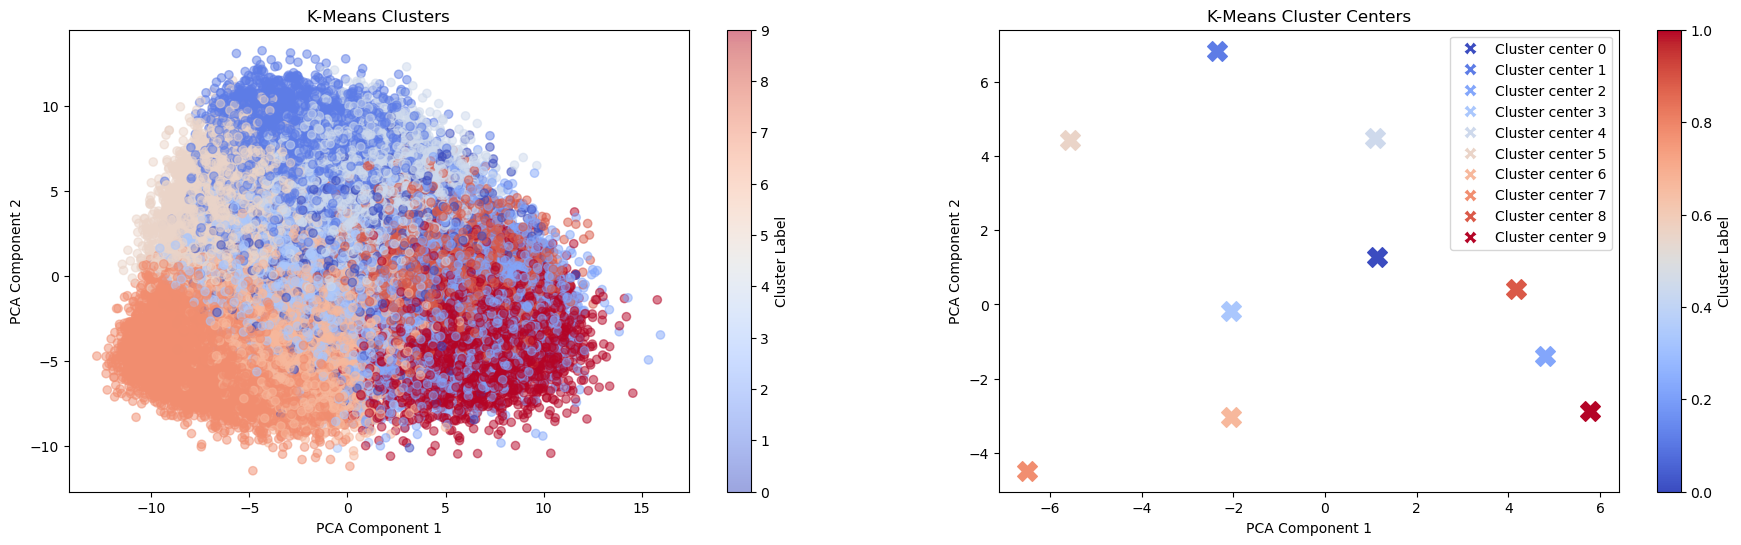

In [62]:
# Using PCA for visualization
pca_2d = PCA(n_components=2)

# Reduced vectors
reduced_vectors_2d = pca_2d.fit_transform(reduced_latent_vectors)

# Cluster centers
cluster_centers = kmeans.cluster_centers_
reduced_centers_2d = pca_2d.transform(cluster_centers)

# Labels and colors
unique_labels = np.unique(labels)
colors = plt.cm.get_cmap('coolwarm', len(unique_labels))  

# Clusters
plt.figure(figsize=(22, 6))
plt.subplot(1, 2, 1)
plt.scatter(reduced_vectors_2d[:, 0], reduced_vectors_2d[:, 1], c=labels, cmap='coolwarm', marker='o', alpha=0.5)
plt.title('K-Means Clusters')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')

plt.subplot(1,2,2)
# Dodanie centrów klastrów z odpowiednimi kolorami
for i, center in enumerate(reduced_centers_2d):
    plt.scatter(center[0], center[1], color=colors(i), marker='X', s=200, label=f'Centrum klastra {i}' if i == 0 else "")

# Cluster Centers
plt.set_cmap("coolwarm")
plt.title('K-Means Cluster Centers')
# plt.xlim((-3.2, 4.2))
# plt.ylim((-3.5, 5))
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster Label')
# Legend
handles = [plt.Line2D([0], [0], marker='X', color='w', markerfacecolor=colors(i), markersize=10) for i in range(len(unique_labels))]
plt.legend(handles, [f'Cluster center {i}' for i in unique_labels])


plt.show()


In [63]:
# Load reduced latent vectors
reduced_latent_vectors = np.load("reduced_latent_vectors_183_michal.npy")

# Perform initial K-Means clustering
kmeans = KMeans(n_clusters=10, random_state=42)
clusters = kmeans.fit_predict(reduced_latent_vectors)

# Load the original CSV file to get the image paths
original_csv = "validate_csv_train.csv"
df = pd.read_csv(original_csv)

# Add cluster assignments to the DataFrame
df["cluster_200"] = clusters
df.head(10)

C:\Users\Adas\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,file,artist,genre,style,cluster_200
0,Mannerism_Late_Renaissance/tintoretto_portrait...,67,135,153,8
1,Northern_Renaissance/hieronymus-bosch_not_dete...,23,136,157,2
2,Impressionism/claude-monet_portrait-of-poly-fi...,4,135,152,8
3,Realism/isaac-levitan_oak-trunk-in-early-summe...,48,133,161,7
4,Art_Nouveau_Modern/raphael-kirchner_cigarettes...,19,139,143,8
5,Rococo/william-hogarth_the-triumph-of-represen...,0,131,162,6
6,Color_Field_Painting/sean-scully_yellow-red-19...,0,129,145,5
7,Romanticism/caspar-david-friedrich_wc-churchya...,0,133,163,6
8,High_Renaissance/pietro-perugino_nativity-1500...,58,136,151,2
9,Mannerism_Late_Renaissance/rosso-fiorentino_mo...,0,136,153,2


In [64]:
# Count the number of images in each cluster
cluster_counts = df["cluster_200"].value_counts().to_dict()
cluster_counts

{7: 10841,
 8: 9567,
 2: 9262,
 6: 9113,
 4: 8755,
 9: 8395,
 3: 7836,
 1: 6278,
 5: 5032,
 0: 4789}

In [65]:
joblib.dump(kmeans, "kmeans_102_clusters_michal#2.pkl")

# Update cluster labels to reflect contiguous numbering
unique_clusters = sorted(cluster_counts.keys())
unique_clusters


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [66]:
# Save cluster information to separate CSVs based on real clusters
output_dir = "clusters_csv_200"
os.makedirs(output_dir, exist_ok=True)

for cluster_num in unique_clusters:
    cluster_df = df[df["cluster_200"] == cluster_num]
    cluster_csv_path = os.path.join(output_dir, f"validated_csv_cluster_{cluster_num}.csv")
    cluster_df.to_csv(cluster_csv_path, index=False)

print(f"Cluster CSV files saved in directory: {output_dir}")


Cluster CSV files saved in directory: clusters_csv_200


# trenowanie autoenkodera do inpaintingu

In [ ]:
import comet_ml
from comet_ml import Experiment

import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image,ImageDraw
import random

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image,ImageDraw
import random
import math
import cv2
import skimage.exposure
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset, random_split

In [ ]:
#try this auto:

import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        identity = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return self.relu(out + identity)  # Add skip connection

class InpaintingAutoencoder(nn.Module):
    def __init__(self):
        super(InpaintingAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
            nn.ReLU(),
            nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 512x14x14
            nn.ReLU(),
            nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),  # 512x7x7
            nn.ReLU()
        )

        # Bottleneck with extended capacity and residual learning
        self.bottleneck = nn.Sequential(
            nn.Conv2d(512, 1024, kernel_size=3, padding=2, dilation=2),  # Dilated convolution
            nn.ReLU(),
            ResidualBlock(1024, 1024),
            nn.Conv2d(1024, 1024, kernel_size=3, padding=4, dilation=4),  # Larger receptive field
            nn.ReLU(),
            ResidualBlock(1024, 1024)
        )

        # Decoder with skip connections and residual blocks
        self.decoder = nn.ModuleDict({
            "deconv4": nn.Sequential(
                nn.ConvTranspose2d(1024 + 512, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
                nn.ReLU(),
                ResidualBlock(256, 256)
            ),
            "deconv3": nn.Sequential(
                nn.ConvTranspose2d(256 + 256, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
                nn.ReLU(),
                ResidualBlock(128, 128)
            ),
            "deconv2": nn.Sequential(
                nn.ConvTranspose2d(128 + 128, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
                nn.ReLU(),
                ResidualBlock(64, 64)
            ),
            "deconv1": nn.Sequential(
                nn.ConvTranspose2d(64 + 64, 3, kernel_size=4, stride=2, padding=1),  # 3x224x224
                nn.Tanh()  # If you normalize inputs to [-1, 1]
            )
        })

    def forward(self, x):
        # Encode input
        enc1 = self.encoder[0:2](x)  # 64x112x112
        enc2 = self.encoder[2:4](enc1)  # 128x56x56
        enc3 = self.encoder[4:6](enc2)  # 256x28x28
        enc4 = self.encoder[6:8](enc3)  # 512x14x14
        bottleneck = self.bottleneck(enc4)  # 1024x7x7

        # Decode with skip connections
        dec4 = self.decoder["deconv4"](torch.cat([bottleneck, enc4], dim=1))  # 256x28x28
        dec3 = self.decoder["deconv3"](torch.cat([dec4, enc3], dim=1))  # 128x56x56
        dec2 = self.decoder["deconv2"](torch.cat([dec3, enc2], dim=1))  # 64x112x112
        dec1 = self.decoder["deconv1"](torch.cat([dec2, enc1], dim=1))  # 3x224x224

        return bottleneck, dec1




In [ ]:
# Train function with save and resume functionality
def train_autoencoder_on_dataset(autoencoder, train_loader, test_loader, save_path, epochs=100, start_epoch=0):
    # Define loss function and optimizer
    criterion = nn.MSELoss() #perceptual + combined losses (perceptual + mse, ssim + mse)
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.001)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5, verbose=True)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)
    for param_group in optimizer.param_groups:
        print(f"Current learning rate: {param_group['lr']}")

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')



    # Load previous checkpoint if it exists
    if start_epoch > 0:
        checkpoint = torch.load(save_path)
        autoencoder.load_state_dict(checkpoint['model_state_dict'])
        #optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        print(f"Resuming training from epoch {start_epoch}...")

    for param_group in optimizer.param_groups:
        print(f"Current learning rate: {param_group['lr']}")
        
    for epoch in range(start_epoch, epochs):
        epoch_loss = 0.0
        autoencoder.train()  # Set the model to training mode

        for original_images, damaged_images in train_loader:
            # Move images to the device
            original_images = original_images.to(device)
            damaged_images = damaged_images.to(device)

            # Zero the gradient buffers
            optimizer.zero_grad()

            # Forward pass
            _, reconstructed_images = autoencoder(damaged_images)

            # Create a mask for penalizing inpainted regions
            mask = (damaged_images == 1.0).all(dim=1, keepdim=True).float()  # Assuming normalized [0, 1] inputs

            # Define the weighted loss
            weight = 5  # Adjust this weight to control the penalty strength
            weighted_loss = ((1 + mask * (weight - 1)) * (reconstructed_images - original_images) ** 2).mean()

            # Backward pass
            weighted_loss.backward()

            # Update weights
            optimizer.step()

            # Accumulate loss for the epoch
            epoch_loss += weighted_loss.item()


        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {epoch_loss / len(train_loader):.6f}")
        # Log training loss to CometML
        train_loss = epoch_loss / len(train_loader)
        experiment.log_metric("train_loss", train_loss, step=epoch+1)

        current_lr = optimizer.param_groups[0]['lr']
        experiment.log_metric("learning_rate", current_lr, step=epoch+1)

        # Evaluate on test data
        autoencoder.eval()  # Set the model to evaluation mode
        test_loss = 0.0
        with torch.no_grad():
            for original_images, damaged_images in test_loader:
                original_images = original_images.to(device)
                damaged_images = damaged_images.to(device)
                _, reconstructed_images = autoencoder(damaged_images)
                loss = criterion(reconstructed_images, original_images)
                test_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Test Loss: {test_loss / len(test_loader):.6f}")
        # Log test loss to CometML
        #test_loss = test_loss / len(test_loader)
        experiment.log_metric("test_loss", test_loss / len(test_loader), step=epoch+1)

        # Save the model state every 10 epochs or at the end
        if (epoch + 1) % 10 == 0 or (epoch + 1) == epochs:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, save_path)
            print(f"Model saved at epoch {epoch+1}.")

# Visualize original, damaged, and reconstructed images
def visualize_images(original, damaged, reconstructed):
    # Convert tensors to images
    original = original.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    damaged = damaged.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    # Plot side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(damaged)
    axes[1].set_title('Damaged Image')
    axes[1].axis('off')

    axes[2].imshow(reconstructed)
    axes[2].set_title('Reconstructed Image')
    axes[2].axis('off')

    plt.show()


In [ ]:
class PreGeneratedMask:
    def __init__(self, mask_max_size=1/16, max_vertices=8, mask_choice="random_polygon"):
        self.mask_max_size = mask_max_size
        self.max_vertices = max_vertices
        self.mask_choice = mask_choice
        self.mask_image = None  # Placeholder for the pre-generated mask

    def generate_mask(self, image_size):
        """Generate the mask once based on image size."""
        im_width, im_height = image_size
        total_pixels = im_width * im_height
        target_pixels = int(total_pixels * self.mask_max_size)

        mask = Image.new("RGB", (im_width, im_height), (0, 0, 0))  # Black background
        draw = ImageDraw.Draw(mask)

        if self.mask_choice == "square":
            side_length = int(target_pixels ** 0.5)
            x = random.randint(0, im_width - side_length)
            y = random.randint(0, im_height - side_length)
            draw.rectangle((x, y, x + side_length, y + side_length), fill=(255, 255, 255))

        elif self.mask_choice == "random_square":
            small_mask_size = 10
            iterations = target_pixels // (small_mask_size * small_mask_size)
            for _ in range(iterations):
                x = random.randint(0, im_width - small_mask_size)
                y = random.randint(0, im_height - small_mask_size)
                draw.rectangle((x, y, x + small_mask_size, y + small_mask_size), fill=(255, 255, 255))

        elif self.mask_choice == "random_polygon":
            num_vertices = random.randint(3, self.max_vertices)
            max_possible_radius = min(im_width, im_height) // 4
            radius = int((target_pixels / (num_vertices * 0.5)) ** 0.5)
            radius = min(radius, max_possible_radius)
            center_x = random.randint(radius, im_width - radius)
            center_y = random.randint(radius, im_height - radius)
            vertices = [
                (
                    int(center_x + radius * np.cos(2 * np.pi * i / num_vertices)),
                    int(center_y + radius * np.sin(2 * np.pi * i / num_vertices))
                )
                for i in range(num_vertices)
            ]
            draw.polygon(vertices, fill=(255, 255, 255))

        self.mask_image = mask

    def apply_mask(self, image):
        """Apply the pre-generated mask to the input image."""
        if self.mask_image is None:
            raise ValueError("Mask has not been generated. Call `generate_mask` first.")
        return Image.composite(self.mask_image, image, self.mask_image.convert("L"))


# Updated Dataset class with pre-generated mask
class WikiArtDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, mask_generator=None):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.mask_generator = mask_generator

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')

        original_image = self.transform(image) if self.transform else image
        damaged_image = None

        if self.mask_generator:
            # Apply the pre-generated mask to create a damaged version
            damaged_image = self.mask_generator.apply_mask(image.copy())
            damaged_image = self.transform(damaged_image) if self.transform else damaged_image

        return original_image, damaged_image




In [ ]:
experiment = Experiment(
    api_key="8mxmnaeDwD4ZptsywLhhkoC53",
    project_name="adv_autoencoder-training_3w_maska_cluster_nowy_SSIM_INPAINTING",
    workspace="un"
)

# Main function
if __name__ == "__main__":
    csv_file = "clusters_csv_200/validated_csv_cluster_9.csv"
    root_dir = os.getcwd()
    save_path = "nowy_autoenkoder_MSE_cluster_9.pth"

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])

    # Create a pre-generated mask generator
    mask_generator = PreGeneratedMask(mask_max_size=1/18, max_vertices=8, mask_choice="random_polygon")

    # Generate the mask once based on the image size
    sample_image = Image.open(os.path.join(root_dir, pd.read_csv(csv_file).iloc[0, 0])).convert('RGB')
    mask_generator.generate_mask(sample_image.size)

    # Create the dataset
    dataset = WikiArtDataset(csv_file=csv_file, root_dir=root_dir, transform=transform, mask_generator=mask_generator)

    # Split into training (90%) and testing (10%) datasets
    torch.manual_seed(42)
    train_size = int(0.9 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Initialize and train the model
    autoencoder = InpaintingAutoencoder()
    autoencoder = autoencoder.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
    start_epoch = 0

    if os.path.exists(save_path):
        checkpoint = torch.load(save_path)
        start_epoch = checkpoint['epoch']
        print(f"Found checkpoint. Last completed epoch: {start_epoch}")

    train_autoencoder_on_dataset(autoencoder, train_loader, test_loader, save_path, epochs=550, start_epoch=start_epoch)
    experiment.end()


# trening autoenkodera do superresolution

In [ ]:
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image,ImageDraw
import random

import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import pandas as pd
import os
from PIL import Image,ImageDraw
import random
import math
import cv2
import skimage.exposure
import torchvision.models as models
import torchvision.transforms as transforms
from tqdm import tqdm

In [ ]:
import torch
import torch.nn as nn


class ResidualBlock(nn.Module):
    def __init__(self, in_channels):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        identity = x
        out = self.relu(self.conv1(x))
        out = self.conv2(out)
        return self.relu(out + identity)


class SuperResolutionAutoencoder(nn.Module):
    def __init__(self):
        super(SuperResolutionAutoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # (3 -> 64 channels)
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Downscale (128 channels)
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Downscale again (256 channels)
            nn.ReLU(inplace=True)
        )

        # Bottleneck (Residual Blocks)
        self.bottleneck = nn.Sequential(
            ResidualBlock(256),
            ResidualBlock(256),
            ResidualBlock(256)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Upscale (256 -> 128)
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Upscale (128 -> 64)
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),  # Output back to 3 channels
            nn.Sigmoid()  # Normalize output to [0, 1] range
        )

    def forward(self, x):
        enc = self.encoder(x)
        bottleneck = self.bottleneck(enc)
        out = self.decoder(bottleneck)
        return out


In [ ]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import random
from torchvision.models import vgg19
from torchvision.transforms import Resize

import torch
import torch.nn as nn
import torch.nn.functional as F
from pytorch_msssim import ssim



# Dataset class for super-resolution
class WikiArtDatasetSuperResolution(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, downscale_factor=2):
        self.df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.downscale_factor = downscale_factor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.df.iloc[idx, 0])
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            original_image = self.transform(image)  # High-resolution image

            # Create a low-resolution image by downscaling and then upscaling
            downscaled_image = transforms.Resize(
                (original_image.shape[1] // self.downscale_factor, original_image.shape[2] // self.downscale_factor)
            )(image)
            low_res_image = transforms.Resize((original_image.shape[1], original_image.shape[2]))(downscaled_image)

            low_res_image = self.transform(low_res_image)

        return original_image, low_res_image


# Train function with save and resume functionality

class CombinedLoss(nn.Module):
    def __init__(self, ssim_weight=0.1, pixel_weight=1.0):
        super(CombinedLoss, self).__init__()
        self.ssim_weight = ssim_weight
        self.pixel_weight = pixel_weight
        self.mse = nn.MSELoss()

    def forward(self, reconstructed, original):
        # Pixel-wise loss (MSE)
        pixel_loss = self.mse(reconstructed, original)
        # Structural Similarity Index Loss (1 - SSIM)
        ssim_loss = 1 - ssim(reconstructed, original, data_range=1, size_average=True)
        # Combined loss
        return self.pixel_weight * pixel_loss + self.ssim_weight * ssim_loss



def train_autoencoder_on_dataset(autoencoder, train_loader, test_loader, save_path, epochs=100, start_epoch=0):
    # Define combined loss function and optimizer
    criterion = CombinedLoss(ssim_weight=0.1, pixel_weight=1.0)
    #criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.0003)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Move the model and loss function to the device
    autoencoder.to(device)
    criterion.to(device)

    # Load previous checkpoint if it exists
    if start_epoch > 0:
        checkpoint = torch.load(save_path)
        autoencoder.load_state_dict(checkpoint['model_state_dict'])
        print(f"Resuming training from epoch {start_epoch}...")

    for epoch in range(start_epoch, epochs):
        epoch_loss = 0.0
        autoencoder.train()  # Set the model to training mode

        # Training loop
        for original_images, damaged_images in train_loader:
            # Move images to the device
            original_images = original_images.to(device)
            damaged_images = damaged_images.to(device)

            # Zero the gradient buffers
            optimizer.zero_grad()

            # Forward pass
            reconstructed_images = autoencoder(damaged_images)

            # Compute the combined loss
            loss = criterion(reconstructed_images, original_images)

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            # Accumulate loss for the epoch
            epoch_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {epoch_loss / len(train_loader):.4f}")

        # Evaluate on test data
        autoencoder.eval()  # Set the model to evaluation mode
        test_loss = 0.0
        with torch.no_grad():
            for original_images, damaged_images in test_loader:
                original_images = original_images.to(device)
                damaged_images = damaged_images.to(device)
                reconstructed_images = autoencoder(damaged_images)
                loss = criterion(reconstructed_images, original_images)
                test_loss += loss.item()

        print(f"Epoch [{epoch+1}/{epochs}], Test Loss: {test_loss / len(test_loader):.4f}")

        # Save the model state every 10 epochs or at the end
        if (epoch + 1) % 5 == 0 or (epoch + 1) == epochs:
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': autoencoder.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
            }, save_path)
            print(f"Model saved at epoch {epoch+1}.")



# Visualize original, damaged, and reconstructed images
def visualize_images(original, damaged, reconstructed):
    # Convert tensors to images
    original = original.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    damaged = damaged.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()

    # Plot side-by-side
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(original)
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(damaged)
    axes[1].set_title('Damaged Image')
    axes[1].axis('off')

    axes[2].imshow(reconstructed)
    axes[2].set_title('Reconstructed Image')
    axes[2].axis('off')

    plt.show()




In [ ]:
if __name__ == "__main__":
    # Path to your CSV file and image directory
    csv_file = "clusters_csv_200/validated_csv_cluster_9.csv"
    root_dir = os.getcwd()
    save_path = "SuperResolutionAutoencoder_combined_loss.pth"

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Target resolution
        transforms.ToTensor()
    ])

    # Create the dataset
    downscale_factor = 2
    dataset = WikiArtDatasetSuperResolution(csv_file=csv_file, root_dir=root_dir, transform=transform, downscale_factor=downscale_factor)

    # Split into training (90%) and testing (10%) datasets
    torch.manual_seed(42)  # You can use any fixed integer seed
    train_size = int(0.9 * len(dataset))
    test_size = len(dataset) - train_size
    train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

    # Create dataloaders
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    # Initialize the autoencoder
    autoencoder = SuperResolutionAutoencoder()
    autoencoder = autoencoder.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

    # Start or resume training
    start_epoch = 0
    if os.path.exists(save_path):
        checkpoint = torch.load(save_path)
        start_epoch = checkpoint['epoch']
        print(f"Found checkpoint. Last completed epoch: {start_epoch}")

    # Train the autoencoder
    train_autoencoder_on_dataset(autoencoder, train_loader, test_loader, save_path, epochs=150, start_epoch=start_epoch)


# prezentacja wyników

Enter the index of the image you want to select:  7
Enter mask choice (square, random_square, random_polygon):  square


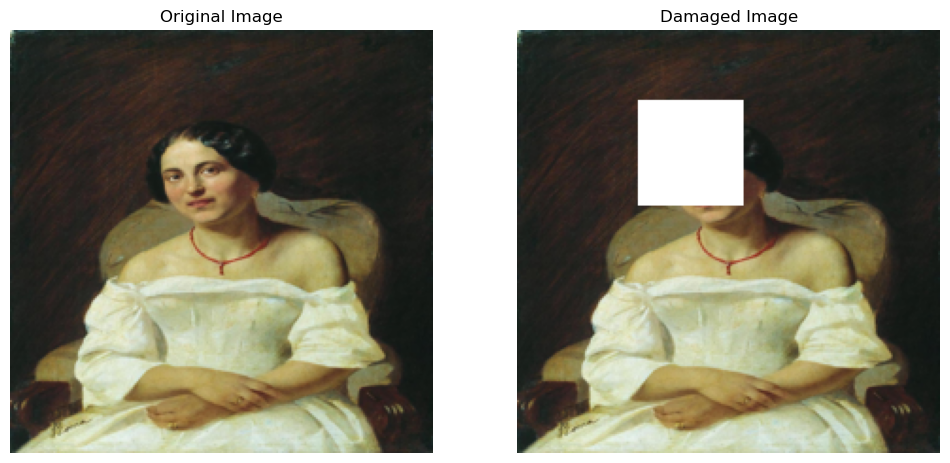

In [7]:
def select_image_for_inpainting():
        
    import os
    import random
    import numpy as np
    import pandas as pd
    from PIL import Image, ImageDraw
    import matplotlib.pyplot as plt
    
    # Define the RandomMask class
    class RandomMask:
        def __init__(self, max_size_fraction=1/16, max_vertices=8, mask_choice=None):
            self.mask_max_size = max_size_fraction
            self.max_vertices = max_vertices
            self.mask_choice = mask_choice
    
        def __call__(self, image):
            if self.mask_choice is None:
                self.mask_choice = random.choice(["square", "random_square", "random_polygon"])
    
            im_width, im_height = image.size
            total_pixels = im_width * im_height
            target_pixels = int(total_pixels * self.mask_max_size)  # Desired damaged pixels
    
            if self.mask_choice == "square":
                side_length = int(target_pixels ** 0.5)
                x = random.randint(0, im_width - side_length)
                y = random.randint(0, im_height - side_length)
                image.paste((255, 255, 255), (x, y, x + side_length, y + side_length))
    
            elif self.mask_choice == "random_square":
                small_mask_size = 10  # Size of small squares
                iterations = target_pixels // (small_mask_size * small_mask_size)
                for _ in range(iterations):
                    x = random.randint(0, im_width - small_mask_size)
                    y = random.randint(0, im_height - small_mask_size)
                    image.paste((255, 255, 255), (x, y, x + small_mask_size, y + small_mask_size))
    
            elif self.mask_choice == "random_polygon":
                draw = ImageDraw.Draw(image)
                num_vertices = random.randint(3, self.max_vertices)
                radius = int((target_pixels / (num_vertices * np.sin(2 * np.pi / num_vertices) * 0.5)) ** 0.5)
    
                # Generate a regular polygon around a random center
                center_x = random.randint(radius, im_width - radius)
                center_y = random.randint(radius, im_height - radius)
                vertices = [
                    (
                        int(center_x + radius * np.cos(2 * np.pi * i / num_vertices)),
                        int(center_y + radius * np.sin(2 * np.pi * i / num_vertices))
                    )
                    for i in range(num_vertices)
                ]
    
                # Draw the polygon
                draw.polygon(vertices, fill=(255, 255, 255))
    
            return image
    
    
    def apply_mask_to_image(image_path, mask_transform):
        # Load the image
        image = Image.open(image_path).convert("RGB")
    
        # Resize the image to 224x224
        image = image.resize((224, 224))
    
        # Apply the mask
        damaged_image = mask_transform(image.copy())
    
        # Display the original and damaged images using matplotlib
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
        # Show original image
        ax[0].imshow(image)
        ax[0].axis('off')
        ax[0].set_title("Original Image")
    
        # Show damaged image
        ax[1].imshow(damaged_image)
        ax[1].axis('off')
        ax[1].set_title("Damaged Image")
    
        plt.show()
    
        return damaged_image
    
    
    # File selection from CSV
    csv_file = "validate_csv_test.csv"
    root_dir = os.getcwd()
    
    # Read CSV and construct full file paths
    try:
        df = pd.read_csv(csv_file)
        file_list = [os.path.join(root_dir, file) for file in df['file']]
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        file_list = []
    
    # Check if the CSV contains any valid file paths
    if not file_list:
        print("No valid image paths found in the CSV file.")
    else:
        # Display available files with indices
        #for idx, file_name in enumerate(file_list):
            #print(f"{idx}: {file_name}")
    
        while True:
            try:
                # Input to select an image by index
                selected_index = int(input("Enter the index of the image you want to select: "))
                if 0 <= selected_index < len(file_list):
                    break
                else:
                    print(f"Please enter a number between 0 and {len(file_list) - 1}.")
            except ValueError:
                print("Invalid input. Please enter a valid integer.")
    
        selected_file = file_list[selected_index]
    
        # Ask the user which mask to apply
        mask_choice = input("Enter mask choice (square, random_square, random_polygon): ").lower()
    
        # Create the mask transformer with the user's choice
        mask_transform = RandomMask(mask_choice=mask_choice if mask_choice else None)
    
        # Apply the mask to the selected image
        test_image = apply_mask_to_image(selected_file, mask_transform)
    
        # Save the resulting damaged image to the 'test_image' variable
        #test_image.save("damaged_image.jpg")  # You can change the file name here if desired
    
        #print("The damaged image has been saved as 'damaged_image.jpg'.")
        original_image = Image.open(selected_file).convert("RGB")
    
        # Resize the image to 224x224
        original_image.resize((224, 224))
        return test_image, original_image, mask_choice
test_image, original_image, mask_choice = select_image_for_inpainting()

In [54]:
mask_choice

'square'

In [3]:
def extract_and_reduce_features_from_image(original_image, model, pca, print_details=False):
    # Add batch size for eval
    #if len(original_image.shape) == 3:
    #    original_image = original_image.unsqueeze(0)
    # Transforms
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    original_image = transform(original_image).unsqueeze(0).to(device)  # Add batch dimension
     
    reduced_latent_space = None
    model.to(device)

    try:
        # Extract latent space
        model.eval()  
        with torch.no_grad():
            original_image = original_image.to(device)
            latent_space = feature_extractor(original_image).cpu().numpy()

        reduced_latent_space = pca.transform(latent_space)
        
        if print_details:
            # Print the latent space
            print("Latent space representation:", latent_space)

            # Reduce the latent space to 102 dimensions using PCA
            print("Reduced latent space representation:", reduced_latent_space)

    except Exception as e:
        print(f"Error processing image: {e}")

    return latent_space, reduced_latent_space


In [11]:
pca_model_path = "pca_4_components_183_michal.pkl"
pca = joblib.load(pca_model_path)

latent_space, reduced_latent_space = extract_and_reduce_features_from_image(test_image, feature_extractor, pca, print_details=False)
latent_space.shape, reduced_latent_space.shape

((1, 512), (1, 183))

In [4]:
# Load Pretrained ResNet18
resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    
latent_dim = 200
    
class FeatureExtractor(nn.Module):
    def __init__(self, base_model):
        super(FeatureExtractor, self).__init__()
        # Feature extractor bez ostatniej warstwy klasyfikacyjnej (fc)
        self.feature_extractor = nn.Sequential(*list(base_model.children())[:-1])
    
    def forward(self, x):
        # Wyciągnięcie cech
        features = self.feature_extractor(x)
        # Spłaszczenie cech: z [batch_size, 512, 1, 1] do [batch_size, 512]
        features = features.view(features.size(0), -1)
        return features
    
feature_extractor = FeatureExtractor(resnet)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = feature_extractor.to(device)

pca_model_path = "pca_4_components_183_michal.pkl"
pca = joblib.load(pca_model_path)
kmeans = joblib.load("kmeans_102_clusters_michal#2.pkl")
labels = kmeans.labels_

def assign_cluster_with_visualization(original_image, model, kmeans, pca, reduced_latent_vectors):

    try:
        #device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        #original_image = transform(original_image).unsqueeze(0).to(device)  # Add batch dimension

        latent_space, reduced_latent_space = extract_and_reduce_features_from_image(original_image, feature_extractor, pca, print_details=False)

        # Cluster centers
        cluster_centers = kmeans.cluster_centers_

        # Distances between latent image reduced latent space and cluster centers
        distances = np.linalg.norm(cluster_centers - reduced_latent_space, axis=1)
        # Closest cluster
        closest_cluster = np.argmin(distances)
        shortest_distance = min(distances)
        # Visualization
        # Using PCA for visualization
        pca_2d = PCA(n_components=2)

        # Reduced vectors
        reduced_vectors_2d = pca_2d.fit_transform(reduced_latent_vectors)

        # Cluster centers
        cluster_centers = kmeans.cluster_centers_
        reduced_centers_2d = pca_2d.transform(cluster_centers)

        # Original image
        original_image_2d = pca_2d.transform(reduced_latent_space)
        original_image_2d = original_image_2d.flatten()

        # Labels and colors
        unique_labels = np.unique(labels)
        colors = plt.cm.get_cmap('coolwarm', len(unique_labels))  

        # Clusters
        plt.figure(figsize=(22, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(reduced_vectors_2d[:, 0], reduced_vectors_2d[:, 1], c=labels, cmap='coolwarm', marker='o', alpha=0.3)
        plt.scatter(original_image_2d[0], original_image_2d[1], c="green", marker="X", s=300)
        plt.title('K-Means Clusters')
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.colorbar(label='Cluster Label')

        plt.subplot(1,2,2)
        # Dodanie centrów klastrów z odpowiednimi kolorami
        for i, center in enumerate(reduced_centers_2d):
            if i == closest_cluster:
                plt.scatter(center[0], center[1], color="green", facecolor="none", marker='o', s=800, label="Closest cluster")
            plt.scatter(center[0], center[1], color=colors(i), marker='X', s=300, label=f"Cluster center {i}")
        # Original image
        plt.scatter(original_image_2d[0], original_image_2d[1], c="green", marker="D", s=300, label="Original image")
        
        # Cluster Centers
        plt.set_cmap("coolwarm")
        plt.title('K-Means Cluster Centers')
        plt.xlim((-10, 15))
        plt.ylim((-10, 10))
        plt.xlabel('PCA Component 1')
        plt.ylabel('PCA Component 2')
        plt.colorbar(label='Cluster Label')
        # Legend
        legend = plt.legend(loc='upper right',  fontsize=10, facecolor='lightgrey', edgecolor='black', framealpha=1, markerscale=0.7)
        plt.show()

        
    except Exception as e:
        print(f"Error assigning test image to a cluster: {e}")

    return closest_cluster
        
reduced_latent_vectors = np.load("reduced_latent_vectors_183_michal.npy")

# Example usage (ensure `test_image_reduced_latent_space` is properly defined):
assigned_cluster = assign_cluster_with_visualization(test_image, feature_extractor, kmeans, pca, reduced_latent_vectors)
#assigned_cluster

Loading autoencoder weights from: autoencoder_weights/square_inpainting_autoencoder_cluster_8_done.pth


C:\Users\Adas\AppData\Local\Temp\ipykernel_16180\2525501910.py:138: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map_location=device)


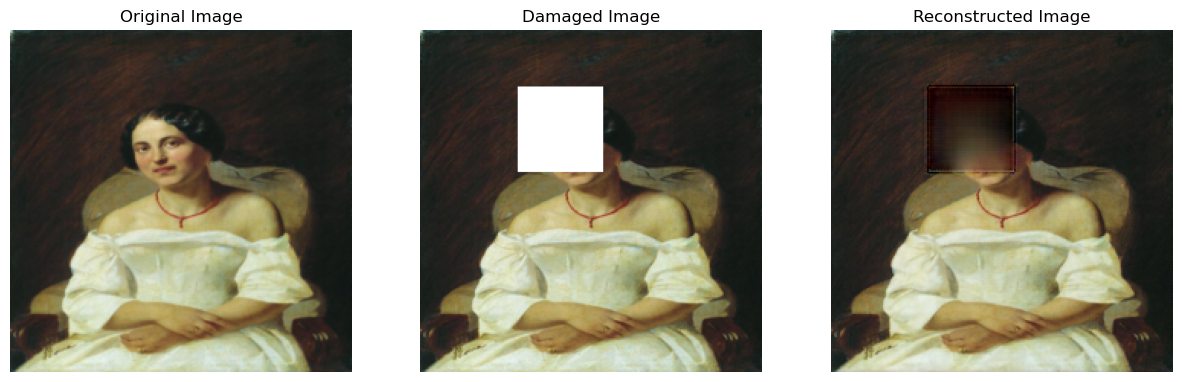

In [9]:
def fix_image(original_image, test_image, mask_choice, assigned_cluster):
    import torch
    import torchvision.transforms as transforms
    import matplotlib.pyplot as plt
    from PIL import Image
    
    
    #try this auto:
    
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    
    class ResidualBlock(nn.Module):
        def __init__(self, in_channels, out_channels):
            super(ResidualBlock, self).__init__()
            self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
            self.relu = nn.ReLU(inplace=True)
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
    
        def forward(self, x):
            identity = x
            out = self.relu(self.conv1(x))
            out = self.conv2(out)
            return self.relu(out + identity)  # Add skip connection
    
    class InpaintingAutoencoder(nn.Module):
        def __init__(self):
            super(InpaintingAutoencoder, self).__init__()
    
            # Encoder
            self.encoder = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
                nn.ReLU(),
                nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
                nn.ReLU(),
                nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
                nn.ReLU(),
                nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 512x14x14
                nn.ReLU(),
                nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),  # 512x7x7
                nn.ReLU()
            )
    
            # Bottleneck with extended capacity and residual learning
            self.bottleneck = nn.Sequential(
                nn.Conv2d(512, 1024, kernel_size=3, padding=2, dilation=2),  # Dilated convolution
                nn.ReLU(),
                ResidualBlock(1024, 1024),
                nn.Conv2d(1024, 1024, kernel_size=3, padding=4, dilation=4),  # Larger receptive field
                nn.ReLU(),
                ResidualBlock(1024, 1024)
            )
    
            # Decoder with skip connections and residual blocks
            self.decoder = nn.ModuleDict({
                "deconv4": nn.Sequential(
                    nn.ConvTranspose2d(1024 + 512, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
                    nn.ReLU(),
                    ResidualBlock(256, 256)
                ),
                "deconv3": nn.Sequential(
                    nn.ConvTranspose2d(256 + 256, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
                    nn.ReLU(),
                    ResidualBlock(128, 128)
                ),
                "deconv2": nn.Sequential(
                    nn.ConvTranspose2d(128 + 128, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
                    nn.ReLU(),
                    ResidualBlock(64, 64)
                ),
                "deconv1": nn.Sequential(
                    nn.ConvTranspose2d(64 + 64, 3, kernel_size=4, stride=2, padding=1),  # 3x224x224
                    nn.Tanh()  # If you normalize inputs to [-1, 1]
                )
            })
    
        def forward(self, x):
            # Encode input
            enc1 = self.encoder[0:2](x)  # 64x112x112
            enc2 = self.encoder[2:4](enc1)  # 128x56x56
            enc3 = self.encoder[4:6](enc2)  # 256x28x28
            enc4 = self.encoder[6:8](enc3)  # 512x14x14
            bottleneck = self.bottleneck(enc4)  # 1024x7x7
    
            # Decode with skip connections
            dec4 = self.decoder["deconv4"](torch.cat([bottleneck, enc4], dim=1))  # 256x28x28
            dec3 = self.decoder["deconv3"](torch.cat([dec4, enc3], dim=1))  # 128x56x56
            dec2 = self.decoder["deconv2"](torch.cat([dec3, enc2], dim=1))  # 64x112x112
            dec1 = self.decoder["deconv1"](torch.cat([dec2, enc1], dim=1))  # 3x224x224
    
            return bottleneck, dec1
    
    
    # Function to preprocess a PIL.Image.Image into a tensor
    def preprocess_image(image, image_size=(224, 224)):
        preprocess = transforms.Compose([
            transforms.Resize(image_size),  # Resize to the expected input size
            transforms.ToTensor(),         # Convert to tensor
        ])
        return preprocess(image).unsqueeze(0)  # Add batch dimension
    
    # Visualize original, damaged, and reconstructed images
    def visualize_images(original, damaged, reconstructed):
        # Convert tensors to images
        original = original.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
        damaged = damaged.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
        reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    
        # Plot side-by-side
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
        axes[0].imshow(original)
        axes[0].set_title('Original Image')
        axes[0].axis('off')
    
        axes[1].imshow(damaged)
        axes[1].set_title('Damaged Image')
        axes[1].axis('off')
    
        axes[2].imshow(reconstructed)
        axes[2].set_title('Reconstructed Image')
        axes[2].axis('off')
    
        plt.show()
    
    
    # Initialize the autoencoder and reconstruct the image
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    autoencoder = InpaintingAutoencoder()
    
    #weights_path = f"inpainting_autoencoder_cluster_{assigned_cluster}_done.pth"
    #weights_path = f"{mask_choice}_inpainting_autoencoder_cluster_{assigned_cluster}_done.pth"
    weights_path = f"autoencoder_weights/{mask_choice}_inpainting_autoencoder_cluster_{assigned_cluster}_done.pth"
    print(f"Loading autoencoder weights from: {weights_path}")
    
    # Load the autoencoder weights
    checkpoint = torch.load(weights_path, map_location=device)
    autoencoder.load_state_dict(checkpoint['model_state_dict'])
    autoencoder = autoencoder.to(device)
    autoencoder.eval()
    
    
    # Preprocess images
    original_image_tensor = preprocess_image(original_image)
    damaged_image_tensor = preprocess_image(test_image)
                
    # Move the damaged image to the correct device and reconstruct it
    damaged_image_tensor = damaged_image_tensor.to(device)
    _, reconstructed_image_tensor = autoencoder(damaged_image_tensor)
                
    # Visualize the result
    visualize_images(original_image_tensor, damaged_image_tensor, reconstructed_image_tensor)


fix_image(original_image, test_image, mask_choice, assigned_cluster)

# GUI

Assigned Cluster: 6
Assigned Cluster: 6
Loading autoencoder weights from: autoencoder_weights/square_inpainting_autoencoder_cluster_6_done.pth
before preprocessing
after preprocessing
after reconstruction
after resize


C:\Users\Adas\AppData\Local\Temp\ipykernel_12084\2349483922.py:423: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map_location=device)


Assigned Cluster: 6
Loading autoencoder weights from: autoencoder_weights/square_inpainting_autoencoder_cluster_6_done.pth


C:\Users\Adas\AppData\Local\Temp\ipykernel_12084\2349483922.py:423: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map_location=device)


before preprocessing
after preprocessing
after reconstruction
after resize
Assigned Cluster: 6
Loading autoencoder weights from: autoencoder_weights/square_inpainting_autoencoder_cluster_6_done.pth


C:\Users\Adas\AppData\Local\Temp\ipykernel_12084\2349483922.py:423: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map_location=device)


before preprocessing
after preprocessing
after reconstruction
after resize
Loading autoencoder weights from: autoencoder_weights/square_inpainting_autoencoder_cluster_6_done.pth
before preprocessing
after preprocessing
after reconstruction
after resize
Assigned Cluster: 6
Loading autoencoder weights from: autoencoder_weights/square_inpainting_autoencoder_cluster_6_done.pth


C:\Users\Adas\AppData\Local\Temp\ipykernel_12084\2349483922.py:423: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map_location=device)


before preprocessing
after preprocessing
after reconstruction
after resize
Assigned Cluster: 6
Loading autoencoder weights from: autoencoder_weights/random_polygon_inpainting_autoencoder_cluster_6_done.pth


C:\Users\Adas\AppData\Local\Temp\ipykernel_12084\2349483922.py:423: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map_location=device)


before preprocessing
after preprocessing
after reconstruction
after resize
Assigned Cluster: 6
Loading autoencoder weights from: autoencoder_weights/square_inpainting_autoencoder_cluster_6_done.pth


C:\Users\Adas\AppData\Local\Temp\ipykernel_12084\2349483922.py:423: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map_location=device)


before preprocessing
after preprocessing
after reconstruction
after resize
Assigned Cluster: 6
Loading autoencoder weights from: autoencoder_weights/square_inpainting_autoencoder_cluster_6_done.pth


C:\Users\Adas\AppData\Local\Temp\ipykernel_12084\2349483922.py:423: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map_location=device)


before preprocessing
after preprocessing
after reconstruction
after resize


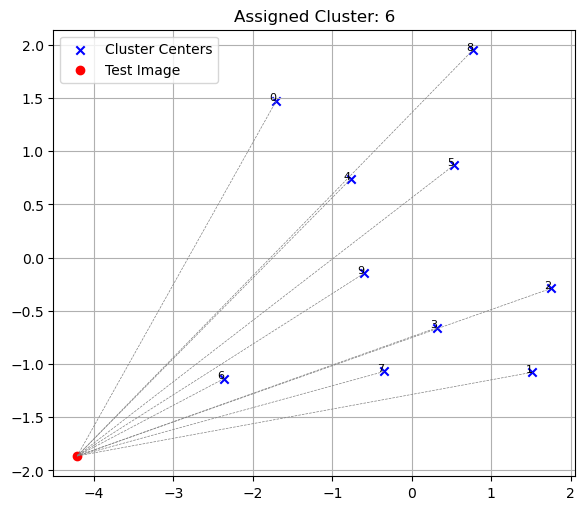

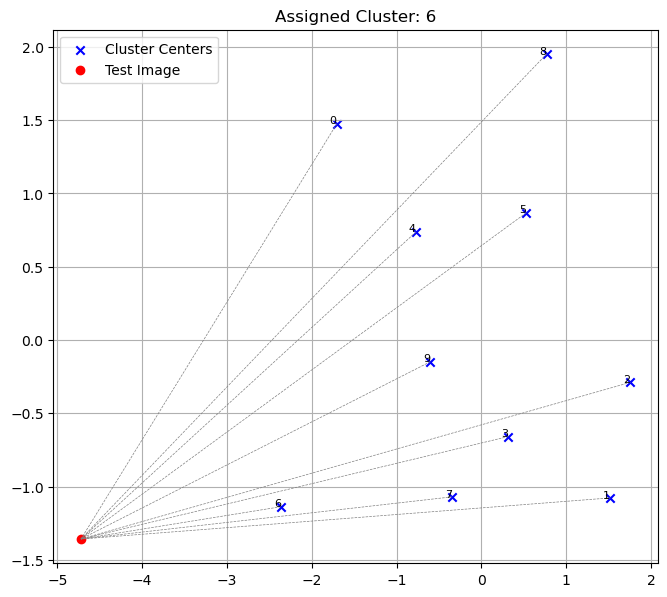

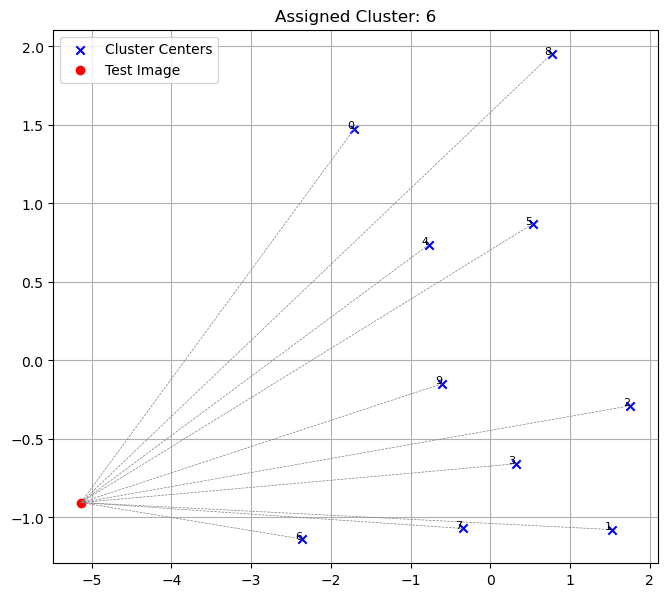

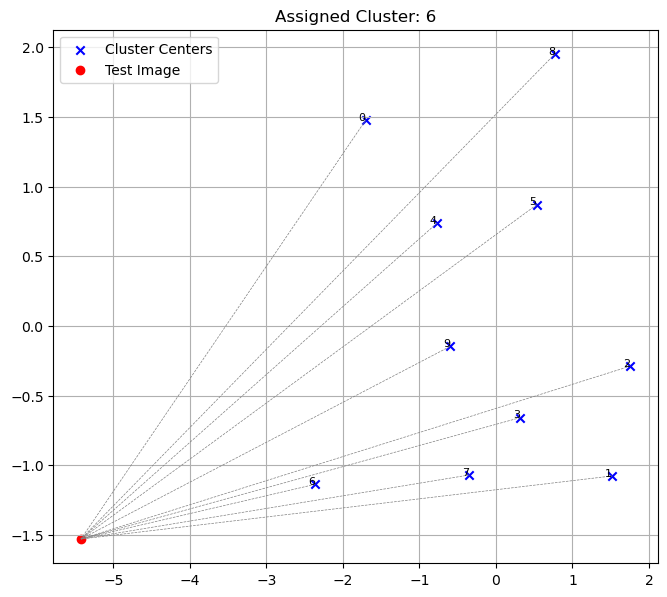

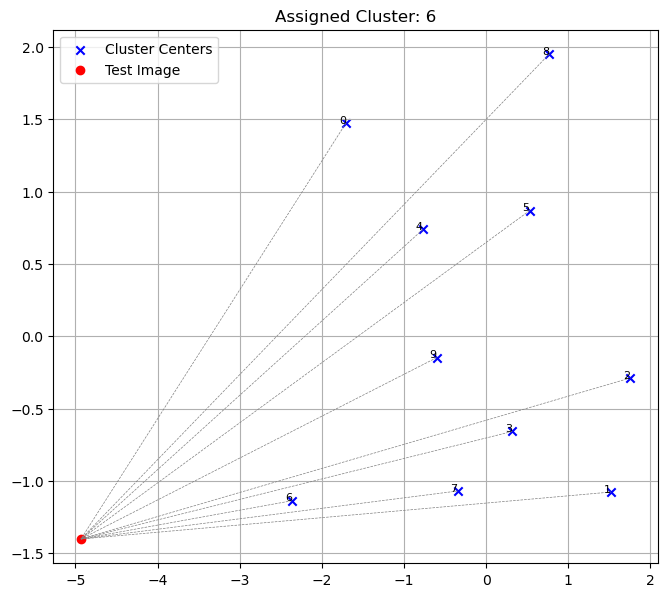

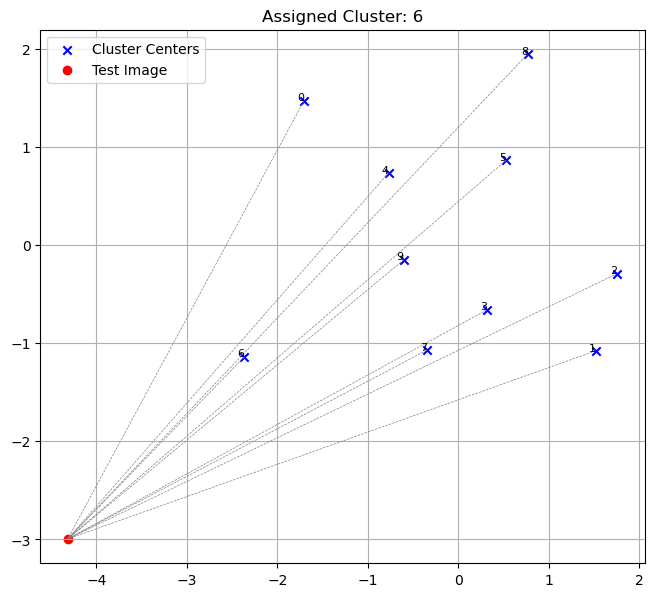

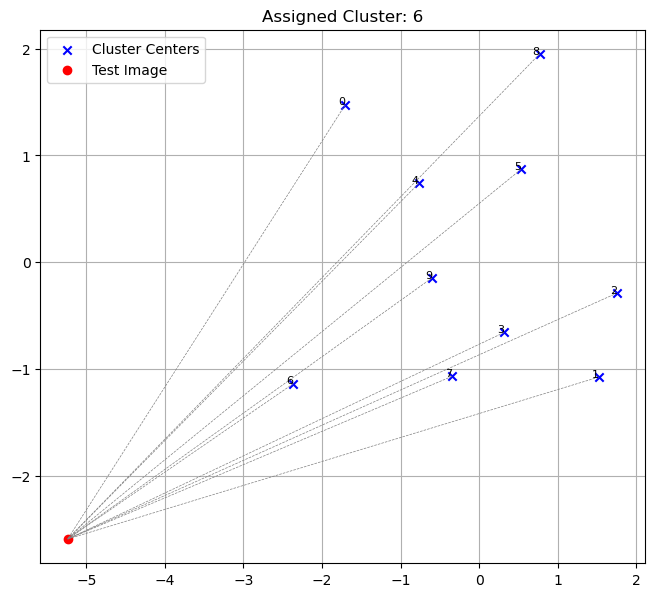

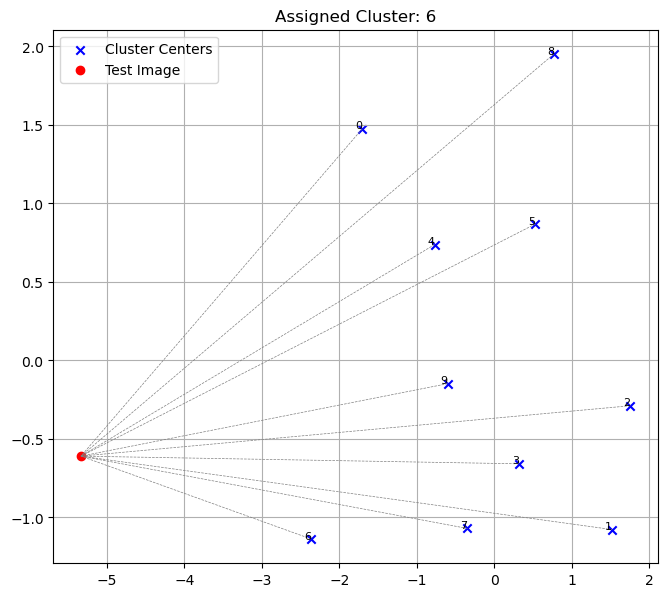

In [20]:
import tkinter as tk
from tkinter import filedialog, simpledialog, messagebox
from tkinter import ttk
from PIL import Image, ImageTk
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
import numpy as np
import joblib
import torch
import torch.nn as nn
from torchvision import models, transforms
from scipy.spatial.distance import cdist


class ImageProcessingGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("Image Processing GUI")
        self.root.geometry("900x600")

        # Frames
        self.control_frame = ttk.Frame(root)
        self.control_frame.pack(side=tk.LEFT, fill=tk.Y, padx=10, pady=10)

        self.display_frame = ttk.Frame(root)
        self.display_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True, padx=10, pady=10)

        # Buttons
        self.btn_select_image = ttk.Button(
            self.control_frame,
            text="Select Image for Inpainting",
            command=self.select_image_for_inpainting
        )
        self.btn_select_image.pack(pady=10, fill=tk.X)

        self.btn_extract_features = ttk.Button(
            self.control_frame,
            text="Extract Features & Assign Cluster",
            command=self.extract_and_assign_cluster
        )
        self.btn_extract_features.pack(pady=10, fill=tk.X)

        self.btn_fix_image = ttk.Button(self.control_frame, text="Fix Image", command=self.fix_image)
        self.btn_fix_image.pack(pady=10, fill=tk.X)

        # Add a button to execute select_image_for_super_resolution
        self.btn_select_super_res_image = ttk.Button(
            self.control_frame,
            text="Select Image for Super Resolution",
            command=self.select_image_for_super_resolution
        )
        self.btn_select_super_res_image.pack(pady=10, fill=tk.X)


        # Canvas for Displaying Images/Plots
        self.canvas = tk.Canvas(self.display_frame)
        self.canvas.pack(fill=tk.BOTH, expand=True)

        self.image_path = None
        self.damaged_image = None
        self.original_image = None
        self.mask_choice = None  # To store the mask choice
        self.assigned_cluster = None

    def clear_display(self):
        for widget in self.display_frame.winfo_children():
            widget.destroy()

    def select_image_for_inpainting(self):
        import pandas as pd
        import os
    
        self.clear_display()
    
        # Define paths
        root_dir = os.getcwd()
        csv_file = "validate_csv_test.csv"
    
        # Read the CSV file and construct a list of valid image paths
        try:
            df = pd.read_csv(csv_file)
            valid_images = df['file'].tolist()  # Extract the 'file' column
            valid_image_paths = [os.path.join(root_dir, image) for image in valid_images]
        except Exception as e:
            messagebox.showerror("Error", f"Failed to read CSV file: {e}")
            return
    
        # Create a Listbox to display the valid images
        listbox_frame = tk.Frame(self.display_frame)
        listbox_frame.pack(fill=tk.X, pady=5)
    
        label = tk.Label(listbox_frame, text="Select an image from the list:")
        label.pack()
    
        image_listbox = tk.Listbox(listbox_frame, height=10, exportselection=False)
        image_listbox.pack(fill=tk.X, padx=5, pady=5)
    
        # Add image names to the Listbox
        for image_name in valid_images:
            image_listbox.insert(tk.END, image_name)
    
        # Define a function to handle image selection
        def on_select_image():
            selected_index = image_listbox.curselection()
            if not selected_index:
                messagebox.showerror("Error", "No image selected!")
                return
    
            selected_image = valid_images[selected_index[0]]
            self.image_path = os.path.join(root_dir, selected_image)
    
            # Apply the rest of the logic only after the selection
            apply_mask_to_image()
    
        select_button = tk.Button(listbox_frame, text="Confirm Selection", command=on_select_image)
        select_button.pack(pady=5)
    
        # Function to apply the mask to the selected image
        def apply_mask_to_image():
            # Prompt user for mask choice
            self.mask_choice = tk.simpledialog.askstring(
                "Mask Choice", "Enter mask choice (square, random_square, random_polygon):"
            )
            self.clear_display()
            if not self.mask_choice:
                return
    
            # Define RandomMask as a local class
            class RandomMask:
                def __init__(self, max_size_fraction=1 / 16, max_vertices=8, mask_choice=None):
                    self.mask_max_size = max_size_fraction
                    self.max_vertices = max_vertices
                    self.mask_choice = mask_choice
    
                def __call__(self, image):
                    import random
                    import numpy as np
                    from PIL import ImageDraw
    
                    if self.mask_choice is None:
                        self.mask_choice = random.choice(["square", "random_square", "random_polygon"])
    
                    im_width, im_height = image.size
                    total_pixels = im_width * im_height
                    target_pixels = int(total_pixels * self.mask_max_size)
    
                    if self.mask_choice == "square":
                        side_length = int(target_pixels ** 0.5)
                        x = random.randint(0, im_width - side_length)
                        y = random.randint(0, im_height - side_length)
                        image.paste((255, 255, 255), (x, y, x + side_length, y + side_length))
    
                    elif self.mask_choice == "random_square":
                        small_mask_size = 10
                        iterations = target_pixels // (small_mask_size * small_mask_size)
                        for _ in range(iterations):
                            x = random.randint(0, im_width - small_mask_size)
                            y = random.randint(0, im_height - small_mask_size)
                            image.paste((255, 255, 255), (x, y, x + small_mask_size, y + small_mask_size))
    
                    elif self.mask_choice == "random_polygon":
                        draw = ImageDraw.Draw(image)
                        num_vertices = random.randint(3, self.max_vertices)
                        radius = int((target_pixels / (num_vertices * np.sin(2 * np.pi / num_vertices) * 0.5)) ** 0.5)
    
                        center_x = random.randint(radius, im_width - radius)
                        center_y = random.randint(radius, im_height - radius)
                        vertices = [
                            (
                                int(center_x + radius * np.cos(2 * np.pi * i / num_vertices)),
                                int(center_y + radius * np.sin(2 * np.pi * i / num_vertices))
                            )
                            for i in range(num_vertices)
                        ]
    
                        draw.polygon(vertices, fill=(255, 255, 255))
    
                    return image
    
            # Apply the mask to the selected image
            mask_transform = RandomMask(mask_choice=self.mask_choice)
            original_image = Image.open(self.image_path).convert("RGB")
            original_image = original_image.resize((224, 224))
            damaged_image = mask_transform(original_image.copy())
    
            # Save to instance variables
            self.original_image = original_image
            self.damaged_image = damaged_image
    
            # Convert to Tkinter-compatible images
            original_tk = ImageTk.PhotoImage(original_image.resize((300, 300)))
            damaged_tk = ImageTk.PhotoImage(damaged_image.resize((300, 300)))
    
            # Display images
            original_label = tk.Label(self.display_frame, text="Original Image")
            original_label.pack()
            original_panel = tk.Label(self.display_frame, image=original_tk)
            original_panel.image = original_tk
            original_panel.pack()
    
            damaged_label = tk.Label(self.display_frame, text="Damaged Image")
            damaged_label.pack()
            damaged_panel = tk.Label(self.display_frame, image=damaged_tk)
            damaged_panel.image = damaged_tk
            damaged_panel.pack()



    def extract_and_assign_cluster(self):
        self.clear_display()

        if not self.damaged_image:
            messagebox.showerror("Error", "No image selected.")
            return

        # Define the model and transformation
        resnet = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        fc_layer = nn.Linear(512, 200)  # Latent space with 200 dimensions

        class ModifiedResNet18(nn.Module):
            def __init__(self, feature_extractor, fc_layer):
                super().__init__()
                self.feature_extractor = feature_extractor
                self.fc_layer = fc_layer

            def forward(self, x):
                features = self.feature_extractor(x).view(x.size(0), -1)
                return self.fc_layer(features)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model = ModifiedResNet18(feature_extractor, fc_layer).to(device)

        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

        try:
            # Process the image
            image_tensor = transform(self.damaged_image).unsqueeze(0).to(device)
            model.eval()
            with torch.no_grad():
                latent_space = model(image_tensor).cpu().numpy()

            # Dimensionality reduction using PCA
            pca = joblib.load("pca_4_components_200.pkl")
            reduced_latent_space = pca.transform(latent_space)

            # Load K-Means model
            kmeans_model = joblib.load("kmeans_102_clusters.pkl")
            cluster_centers = kmeans_model.cluster_centers_

            # Compute distances to clusters
            distances = cdist(reduced_latent_space, cluster_centers, metric='euclidean')
            nearest_cluster = np.argmin(distances)
            print(f"Assigned Cluster: {nearest_cluster}")
            self.assigned_cluster = nearest_cluster

            # Visualization
            plt.figure(figsize=(8, 6))
            plt.scatter(cluster_centers[:, 0], cluster_centers[:, 1], c='blue', label='Cluster Centers', marker='x')
            plt.scatter(reduced_latent_space[0, 0], reduced_latent_space[0, 1], c='red', label='Test Image', marker='o')
            for i, center in enumerate(cluster_centers):
                plt.annotate(str(i), (center[0], center[1]), fontsize=8, ha='right')
                plt.plot([center[0], reduced_latent_space[0, 0]], [center[1], reduced_latent_space[0, 1]],
                         linestyle='--', color='gray', linewidth=0.5)
            plt.title(f"Assigned Cluster: {nearest_cluster}")
            plt.legend()
            plt.grid(True)

            # Embed the plot in the Tkinter GUI
            canvas = FigureCanvasTkAgg(plt.gcf(), master=self.display_frame)
            canvas_widget = canvas.get_tk_widget()
            canvas_widget.pack(fill=tk.BOTH, expand=True)
            canvas.draw()

        except Exception as e:
            messagebox.showerror("Error", f"Failed to process image: {e}")

    def fix_image(self):
        self.clear_display()
        
        if not self.damaged_image:
            messagebox.showerror("Error", "No damaged image available for fixing.")
            return

        if not self.mask_choice:
            messagebox.showerror("Error", "Mask choice is not set. Please select an image first.")
            return
    
        try:
            import torch
            import torch.nn as nn
            import torchvision.transforms as transforms
            from PIL import Image
            import matplotlib.pyplot as plt
    
            class ResidualBlock(nn.Module):
                def __init__(self, in_channels, out_channels):
                    super(ResidualBlock, self).__init__()
                    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
                    self.relu = nn.ReLU(inplace=True)
                    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
            
                def forward(self, x):
                    identity = x
                    out = self.relu(self.conv1(x))
                    out = self.conv2(out)
                    return self.relu(out + identity)  # Add skip connection
            
            class InpaintingAutoencoder(nn.Module):
                def __init__(self):
                    super(InpaintingAutoencoder, self).__init__()
            
                    # Encoder
                    self.encoder = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
                        nn.ReLU(),
                        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
                        nn.ReLU(),
                        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
                        nn.ReLU(),
                        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 512x14x14
                        nn.ReLU(),
                        nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),  # 512x7x7
                        nn.ReLU()
                    )
            
                    # Bottleneck with extended capacity and residual learning
                    self.bottleneck = nn.Sequential(
                        nn.Conv2d(512, 1024, kernel_size=3, padding=2, dilation=2),  # Dilated convolution
                        nn.ReLU(),
                        ResidualBlock(1024, 1024),
                        nn.Conv2d(1024, 1024, kernel_size=3, padding=4, dilation=4),  # Larger receptive field
                        nn.ReLU(),
                        ResidualBlock(1024, 1024)
                    )
            
                    # Decoder with skip connections and residual blocks
                    self.decoder = nn.ModuleDict({
                        "deconv4": nn.Sequential(
                            nn.ConvTranspose2d(1024 + 512, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
                            nn.ReLU(),
                            ResidualBlock(256, 256)
                        ),
                        "deconv3": nn.Sequential(
                            nn.ConvTranspose2d(256 + 256, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
                            nn.ReLU(),
                            ResidualBlock(128, 128)
                        ),
                        "deconv2": nn.Sequential(
                            nn.ConvTranspose2d(128 + 128, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
                            nn.ReLU(),
                            ResidualBlock(64, 64)
                        ),
                        "deconv1": nn.Sequential(
                            nn.ConvTranspose2d(64 + 64, 3, kernel_size=4, stride=2, padding=1),  # 3x224x224
                            nn.Tanh()  # If you normalize inputs to [-1, 1]
                        )
                    })
            
                def forward(self, x):
                    # Encode input
                    enc1 = self.encoder[0:2](x)  # 64x112x112
                    enc2 = self.encoder[2:4](enc1)  # 128x56x56
                    enc3 = self.encoder[4:6](enc2)  # 256x28x28
                    enc4 = self.encoder[6:8](enc3)  # 512x14x14
                    bottleneck = self.bottleneck(enc4)  # 1024x7x7
            
                    # Decode with skip connections
                    dec4 = self.decoder["deconv4"](torch.cat([bottleneck, enc4], dim=1))  # 256x28x28
                    dec3 = self.decoder["deconv3"](torch.cat([dec4, enc3], dim=1))  # 128x56x56
                    dec2 = self.decoder["deconv2"](torch.cat([dec3, enc2], dim=1))  # 64x112x112
                    dec1 = self.decoder["deconv1"](torch.cat([dec2, enc1], dim=1))  # 3x224x224
            
                    return bottleneck, dec1

            # Function to preprocess a PIL.Image.Image into a tensor
            def preprocess_image(image, image_size=(224, 224)):
                preprocess = transforms.Compose([
                    transforms.Resize(image_size),  # Resize to the expected input size
                    transforms.ToTensor(),         # Convert to tensor
                ])
                return preprocess(image).unsqueeze(0)  # Add batch dimension
            
            # Visualize original, damaged, and reconstructed images
            def visualize_images(original, damaged, reconstructed):
                # Convert tensors to images
                original = original.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
                damaged = damaged.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
                reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
            
                # Plot side-by-side
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
                axes[0].imshow(original)
                axes[0].set_title('Original Image')
                axes[0].axis('off')
            
                axes[1].imshow(damaged)
                axes[1].set_title('Damaged Image')
                axes[1].axis('off')
            
                axes[2].imshow(reconstructed)
                axes[2].set_title('Reconstructed Image')
                axes[2].axis('off')
            
                plt.show()
            
    
            # Initialize the autoencoder and reconstruct the image
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            autoencoder = InpaintingAutoencoder()
            
            #weights_path = f"inpainting_autoencoder_cluster_{assigned_cluster}_done.pth"
            #weights_path = f"{mask_choice}_inpainting_autoencoder_cluster_{assigned_cluster}_done.pth"
            weights_path = f"autoencoder_weights/{self.mask_choice}_inpainting_autoencoder_cluster_{self.assigned_cluster}_done.pth"
            print(f"Loading autoencoder weights from: {weights_path}")
            
            # Load the autoencoder weights
            checkpoint = torch.load(weights_path, map_location=device)
            autoencoder.load_state_dict(checkpoint['model_state_dict'])
            autoencoder = autoencoder.to(device)
            autoencoder.eval()
            
            
            # Preprocess images
            original_image_tensor = preprocess_image(self.original_image)
            damaged_image_tensor = preprocess_image(self.damaged_image)
            
                        
            # Move the damaged image to the correct device and reconstruct it
            damaged_image_tensor = damaged_image_tensor.to(device)
            _, reconstructed_image_tensor = autoencoder(damaged_image_tensor)
            
    
            # Update GUI with results
            #damaged_tk = ImageTk.PhotoImage(self.damaged_image.resize((224, 224)))
            #reconstructed_tk = ImageTk.PhotoImage(reconstructed_image_tensor.resize((224, 224)))

            # Convert the tensor to a PIL Image
            reconstructed_image_np = reconstructed_image_tensor.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
            reconstructed_image_pil = Image.fromarray((reconstructed_image_np * 255).astype('uint8'))
            
            # Resize and convert to PhotoImage
            reconstructed_image_pil_resized = reconstructed_image_pil.resize((424, 424))
            reconstructed_tk = ImageTk.PhotoImage(reconstructed_image_pil_resized)



            
            #damaged_label = tk.Label(self.display_frame, text="Damaged Image")
            #damaged_label.pack()
            #damaged_panel = tk.Label(self.display_frame, image=damaged_tk)
            #damaged_panel.image = damaged_tk
            #damaged_panel.pack()
    
            reconstructed_label = tk.Label(self.display_frame, text="Reconstructed Image")
            reconstructed_label.pack()
            reconstructed_panel = tk.Label(self.display_frame, image=reconstructed_tk)
            reconstructed_panel.image = reconstructed_tk
            reconstructed_panel.pack()
    
        except Exception as e:
            messagebox.showerror("Error", f"Failed to reconstruct image: {e}")

    def select_image_for_super_resolution(self):
        import pandas as pd
        import os
    
        self.clear_display()
    
        # Define paths
        root_dir = os.getcwd()
        csv_file = "validate_csv_test.csv"
    
        # Read the CSV file and construct a list of valid image paths
        try:
            df = pd.read_csv(csv_file)
            valid_images = df['file'].tolist()  # Extract the 'file' column
            valid_image_paths = [os.path.join(root_dir, image) for image in valid_images]
        except Exception as e:
            messagebox.showerror("Error", f"Failed to read CSV file: {e}")
            return
    
        # Create a Listbox to display the valid images
        listbox_frame = tk.Frame(self.display_frame)
        listbox_frame.pack(fill=tk.X, pady=5)
    
        label = tk.Label(listbox_frame, text="Select an image from the list:")
        label.pack()
    
        image_listbox = tk.Listbox(listbox_frame, height=10, exportselection=False)
        image_listbox.pack(fill=tk.X, padx=5, pady=5)
    
        # Add image names to the Listbox
        for image_name in valid_images:
            image_listbox.insert(tk.END, image_name)
    
        # Define a function to handle image selection
        def on_select_image():
            selected_index = image_listbox.curselection()
            if not selected_index:
                messagebox.showerror("Error", "No image selected!")
                return
    
            selected_image = valid_images[selected_index[0]]
            self.image_path = os.path.join(root_dir, selected_image)
    
            # Apply the rest of the logic only after the selection
            generate_low_resolution_image()
    
        select_button = tk.Button(listbox_frame, text="Confirm Selection", command=on_select_image)
        select_button.pack(pady=5)
    
        # Function to generate the low-resolution image
        def generate_low_resolution_image():
            self.clear_display()
    
            # Parameters
            downscale_factor = 2
    
            # Load and process the image
            original_image = Image.open(self.image_path).convert("RGB")
            original_image = original_image.resize((224, 224))  # High-resolution image
    
            # Create the low-resolution image by downscaling and upscaling
            downscaled_size = (original_image.width // downscale_factor, original_image.height // downscale_factor)
            downscaled_image = original_image.resize(downscaled_size, Image.BICUBIC)  # Downscale
            low_res_image = downscaled_image.resize((original_image.width, original_image.height), Image.BICUBIC)  # Upscale
    
            # Save to instance variables
            self.original_image = original_image
            self.damaged_image = low_res_image
    
            # Convert to Tkinter-compatible images
            original_tk = ImageTk.PhotoImage(original_image.resize((300, 300)))
            low_res_tk = ImageTk.PhotoImage(low_res_image.resize((300, 300)))
    
            # Display images
            original_label = tk.Label(self.display_frame, text="Original Image")
            original_label.pack()
            original_panel = tk.Label(self.display_frame, image=original_tk)
            original_panel.image = original_tk
            original_panel.pack()
    
            low_res_label = tk.Label(self.display_frame, text="Low-Resolution Image")
            low_res_label.pack()
            low_res_panel = tk.Label(self.display_frame, image=low_res_tk)
            low_res_panel.image = low_res_tk
            low_res_panel.pack()


if __name__ == "__main__":
    root = tk.Tk()
    app = ImageProcessingGUI(root)
    root.mainloop()


C:\Users\Adas\AppData\Local\Temp\ipykernel_14984\661155723.py:61: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('coolwarm', len(unique_labels))


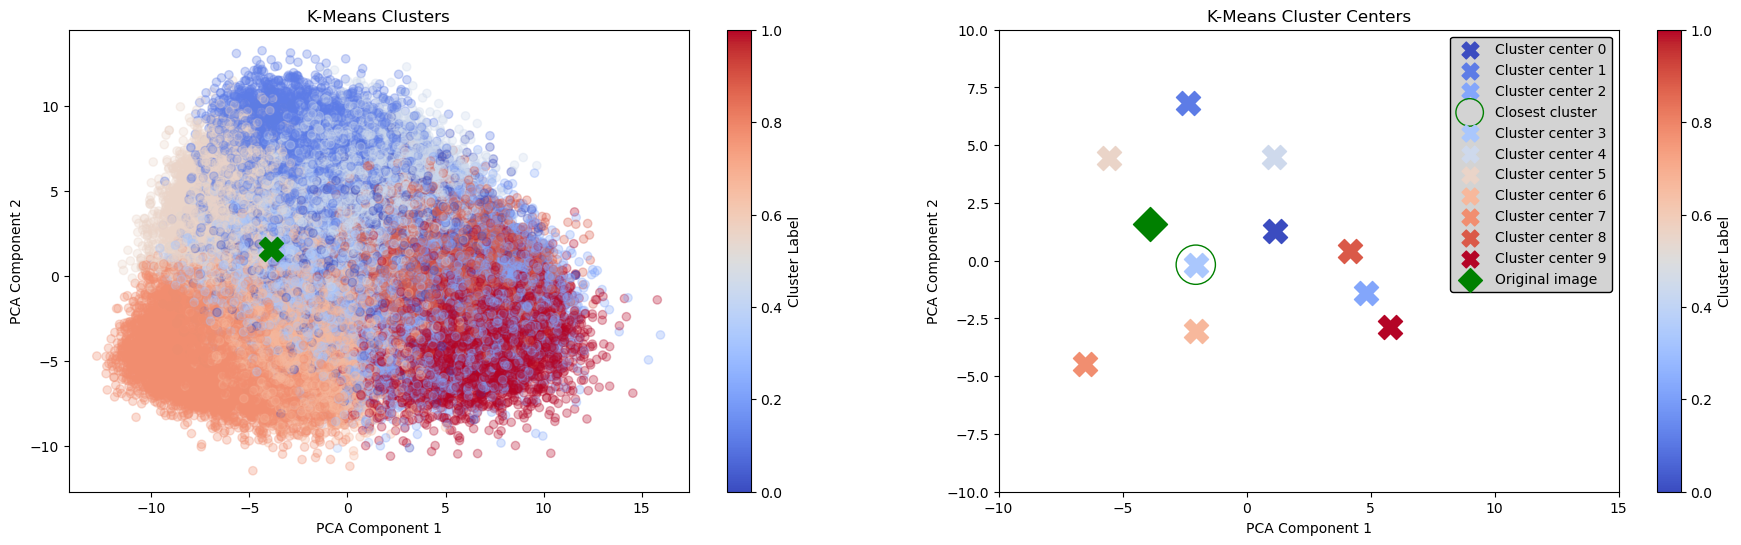

Loading autoencoder weights from: autoencoder_weights/square_inpainting_autoencoder_cluster_3_done.pth


C:\Users\Adas\AppData\Local\Temp\ipykernel_14984\1143005465.py:375: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map_location=device)


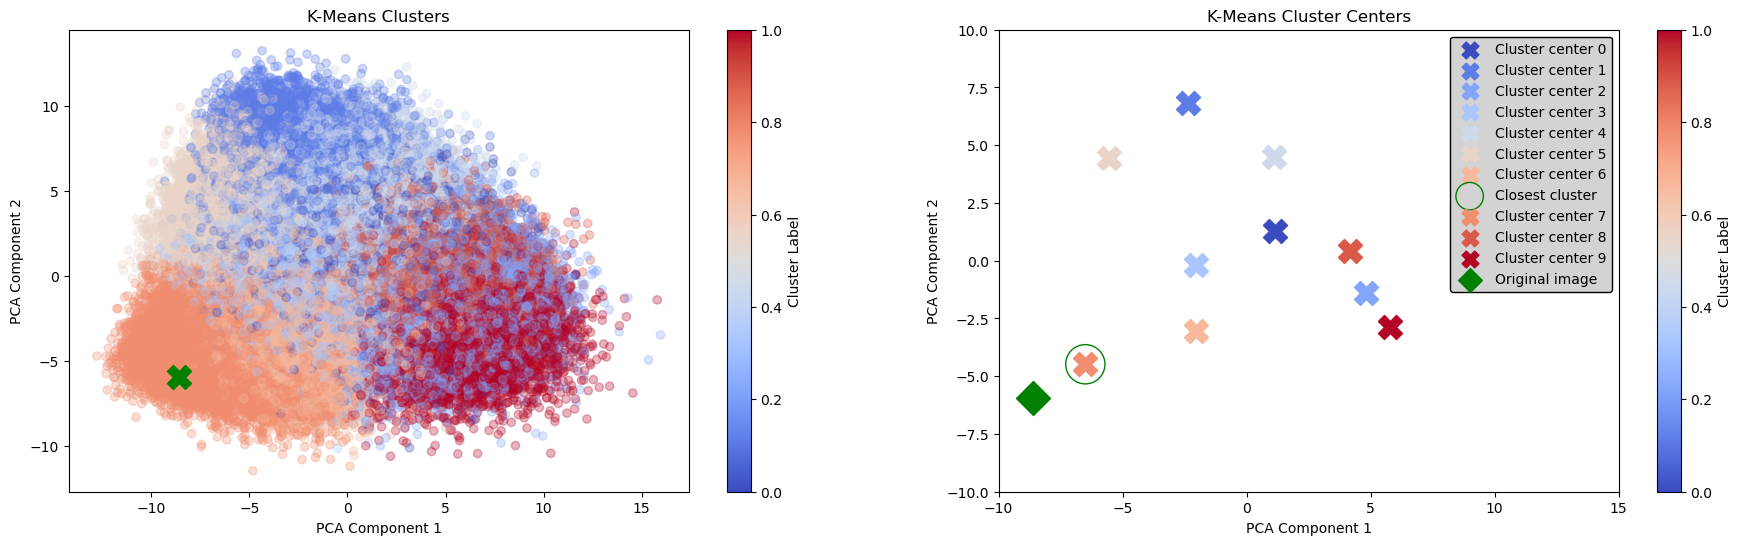

Loading autoencoder weights from: autoencoder_weights/square_inpainting_autoencoder_cluster_7_done.pth


C:\Users\Adas\AppData\Local\Temp\ipykernel_14984\1143005465.py:375: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map_location=device)


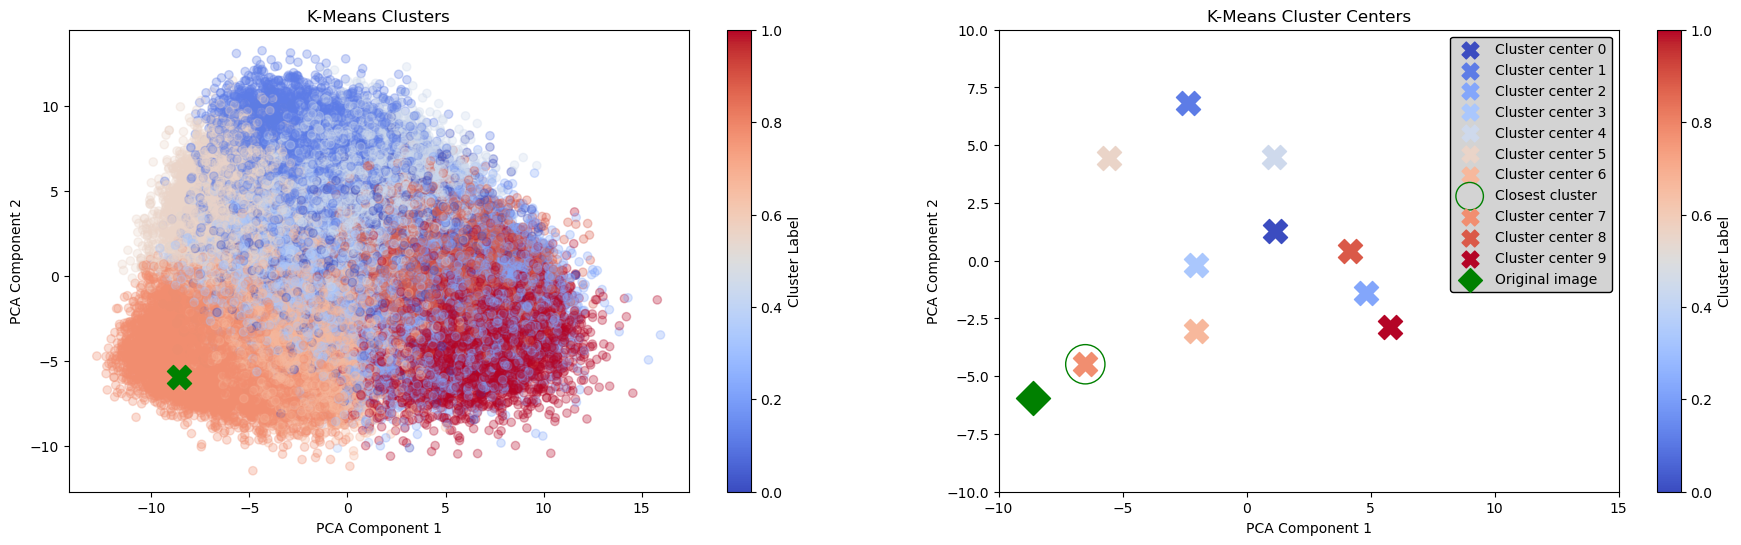

Loading autoencoder weights from: autoencoder_weights/square_inpainting_autoencoder_cluster_7_done.pth


C:\Users\Adas\AppData\Local\Temp\ipykernel_14984\1143005465.py:375: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(weights_path, map_location=device)


In [7]:
import torch
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from tkinter import messagebox, simpledialog
from PIL import Image, ImageTk
import tkinter as tk
from tkinter import ttk
import os
import pandas as pd
from torchvision import models
import torch.nn as nn


class ImageProcessingGUI:
    def __init__(self, root):
        self.root = root
        self.root.title("Image Processing GUI")
        self.root.geometry("900x600")

        # Frames
        self.control_frame = ttk.Frame(root)
        self.control_frame.pack(side=tk.LEFT, fill=tk.Y, padx=10, pady=10)

        self.display_frame = ttk.Frame(root)
        self.display_frame.pack(side=tk.RIGHT, fill=tk.BOTH, expand=True, padx=10, pady=10)

        # Buttons
        self.btn_select_image = ttk.Button(
            self.control_frame,
            text="Select Image for Inpainting",
            command=self.select_image_for_inpainting
        )
        self.btn_select_image.pack(pady=10, fill=tk.X)

        self.btn_assign_cluster = ttk.Button(
            self.control_frame,
            text="Assign Cluster & Visualize",
            command=self.assign_cluster
        )
        self.btn_assign_cluster.pack(pady=10, fill=tk.X)

        self.btn_fix_image = ttk.Button(self.control_frame, text="Fix Image", command=self.fix_image)
        self.btn_fix_image.pack(pady=10, fill=tk.X)

        # Add a button to execute select_image_for_super_resolution
        self.btn_select_super_res_image = ttk.Button(
            self.control_frame,
            text="Select Image for Super Resolution",
            command=self.select_image_for_super_resolution
        )
        self.btn_select_super_res_image.pack(pady=10, fill=tk.X)
        
        
        self.btn_upscale_image = ttk.Button(self.control_frame, text="Upscale Image", command=self.upscale_image)
        self.btn_upscale_image.pack(pady=10, fill=tk.X)
        

        

        # Canvas for Displaying Images/Plots
        self.canvas = tk.Canvas(self.display_frame)
        self.canvas.pack(fill=tk.BOTH, expand=True)

        self.image_path = None
        self.damaged_image = None
        self.original_image = None
        self.mask_choice = None  # To store the mask choice
        self.assigned_cluster = None

    def clear_display(self):
        for widget in self.display_frame.winfo_children():
            widget.destroy()

    def select_image_for_inpainting(self):
        import pandas as pd
        import os
    
        self.clear_display()
    
        # Define paths
        root_dir = os.getcwd()
        csv_file = "validate_csv_test.csv"
    
        # Read the CSV file and construct a list of valid image paths
        try:
            df = pd.read_csv(csv_file)
            valid_images = df['file'].tolist()  # Extract the 'file' column
            valid_image_paths = [os.path.join(root_dir, image) for image in valid_images]
        except Exception as e:
            messagebox.showerror("Error", f"Failed to read CSV file: {e}")
            return
    
        # Create a Listbox to display the valid images
        listbox_frame = tk.Frame(self.display_frame)
        listbox_frame.pack(fill=tk.X, pady=5)
    
        label = tk.Label(listbox_frame, text="Select an image from the list:")
        label.pack()
    
        image_listbox = tk.Listbox(listbox_frame, height=10, exportselection=False)
        image_listbox.pack(fill=tk.X, padx=5, pady=5)
    
        # Add image names to the Listbox
        for image_name in valid_images:
            image_listbox.insert(tk.END, image_name)
    
        # Define a function to handle image selection
        def on_select_image():
            selected_index = image_listbox.curselection()
            if not selected_index:
                messagebox.showerror("Error", "No image selected!")
                return
    
            selected_image = valid_images[selected_index[0]]
            self.image_path = os.path.join(root_dir, selected_image)
    
            # Apply the rest of the logic only after the selection
            apply_mask_to_image()
    
        select_button = tk.Button(listbox_frame, text="Confirm Selection", command=on_select_image)
        select_button.pack(pady=5)
    
        # Function to apply the mask to the selected image
        def apply_mask_to_image():
            # Prompt user for mask choice
            self.mask_choice = tk.simpledialog.askstring(
                "Mask Choice", "Enter mask choice (square, random_square, random_polygon):"
            )
            self.clear_display()
            if not self.mask_choice:
                return
    
            # Define RandomMask as a local class
            class RandomMask:
                def __init__(self, max_size_fraction=1 / 16, max_vertices=8, mask_choice=None):
                    self.mask_max_size = max_size_fraction
                    self.max_vertices = max_vertices
                    self.mask_choice = mask_choice
    
                def __call__(self, image):
                    import random
                    import numpy as np
                    from PIL import ImageDraw
    
                    if self.mask_choice is None:
                        self.mask_choice = random.choice(["square", "random_square", "random_polygon"])
    
                    im_width, im_height = image.size
                    total_pixels = im_width * im_height
                    target_pixels = int(total_pixels * self.mask_max_size)
    
                    if self.mask_choice == "square":
                        side_length = int(target_pixels ** 0.5)
                        x = random.randint(0, im_width - side_length)
                        y = random.randint(0, im_height - side_length)
                        image.paste((255, 255, 255), (x, y, x + side_length, y + side_length))
    
                    elif self.mask_choice == "random_square":
                        small_mask_size = 10
                        iterations = target_pixels // (small_mask_size * small_mask_size)
                        for _ in range(iterations):
                            x = random.randint(0, im_width - small_mask_size)
                            y = random.randint(0, im_height - small_mask_size)
                            image.paste((255, 255, 255), (x, y, x + small_mask_size, y + small_mask_size))
    
                    elif self.mask_choice == "random_polygon":
                        draw = ImageDraw.Draw(image)
                        num_vertices = random.randint(3, self.max_vertices)
                        radius = int((target_pixels / (num_vertices * np.sin(2 * np.pi / num_vertices) * 0.5)) ** 0.5)
    
                        center_x = random.randint(radius, im_width - radius)
                        center_y = random.randint(radius, im_height - radius)
                        vertices = [
                            (
                                int(center_x + radius * np.cos(2 * np.pi * i / num_vertices)),
                                int(center_y + radius * np.sin(2 * np.pi * i / num_vertices))
                            )
                            for i in range(num_vertices)
                        ]
    
                        draw.polygon(vertices, fill=(255, 255, 255))
    
                    return image
    
            # Apply the mask to the selected image
            mask_transform = RandomMask(mask_choice=self.mask_choice)
            original_image = Image.open(self.image_path).convert("RGB")
            original_image = original_image.resize((224, 224))
            damaged_image = mask_transform(original_image.copy())
    
            # Save to instance variables
            self.original_image = original_image
            self.damaged_image = damaged_image
    
            # Convert to Tkinter-compatible images
            original_tk = ImageTk.PhotoImage(original_image.resize((300, 300)))
            damaged_tk = ImageTk.PhotoImage(damaged_image.resize((300, 300)))
    
            # Display images
            original_label = tk.Label(self.display_frame, text="Original Image")
            original_label.pack()
            original_panel = tk.Label(self.display_frame, image=original_tk)
            original_panel.image = original_tk
            original_panel.pack()
    
            damaged_label = tk.Label(self.display_frame, text="Damaged Image")
            damaged_label.pack()
            damaged_panel = tk.Label(self.display_frame, image=damaged_tk)
            damaged_panel.image = damaged_tk
            damaged_panel.pack()

    def assign_cluster(self):
        try:
            # Assuming kmeans, pca, and reduced_latent_vectors are loaded as before
            kmeans = joblib.load("kmeans_102_clusters_michal#2.pkl")
            pca = joblib.load("pca_4_components_183_michal.pkl")
            reduced_latent_vectors = np.load("reduced_latent_vectors_183_michal.npy")

            if self.original_image:
                # Extract features and perform clustering
                closest_cluster = assign_cluster_with_visualization(self.original_image, feature_extractor, kmeans, pca, reduced_latent_vectors)
                self.assigned_cluster = closest_cluster

                messagebox.showinfo("Clustering Result", f"The image was assigned to cluster {closest_cluster}.")
            else:
                messagebox.showerror("Error", "Please select an image first.")
        except Exception as e:
            messagebox.showerror("Error", f"An error occurred during clustering: {e}")


    def fix_image(self):
        self.clear_display()
        
        if not self.damaged_image:
            messagebox.showerror("Error", "No damaged image available for fixing.")
            return

        if not self.mask_choice:
            messagebox.showerror("Error", "Mask choice is not set. Please select an image first.")
            return
    
        try:
            import torch
            import torch.nn as nn
            import torchvision.transforms as transforms
            from PIL import Image
            import matplotlib.pyplot as plt
    
            class ResidualBlock(nn.Module):
                def __init__(self, in_channels, out_channels):
                    super(ResidualBlock, self).__init__()
                    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
                    self.relu = nn.ReLU(inplace=True)
                    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)
            
                def forward(self, x):
                    identity = x
                    out = self.relu(self.conv1(x))
                    out = self.conv2(out)
                    return self.relu(out + identity)  # Add skip connection
            
            class InpaintingAutoencoder(nn.Module):
                def __init__(self):
                    super(InpaintingAutoencoder, self).__init__()
            
                    # Encoder
                    self.encoder = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
                        nn.ReLU(),
                        nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
                        nn.ReLU(),
                        nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
                        nn.ReLU(),
                        nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1),  # 512x14x14
                        nn.ReLU(),
                        nn.Conv2d(512, 512, kernel_size=4, stride=2, padding=1),  # 512x7x7
                        nn.ReLU()
                    )
            
                    # Bottleneck with extended capacity and residual learning
                    self.bottleneck = nn.Sequential(
                        nn.Conv2d(512, 1024, kernel_size=3, padding=2, dilation=2),  # Dilated convolution
                        nn.ReLU(),
                        ResidualBlock(1024, 1024),
                        nn.Conv2d(1024, 1024, kernel_size=3, padding=4, dilation=4),  # Larger receptive field
                        nn.ReLU(),
                        ResidualBlock(1024, 1024)
                    )
            
                    # Decoder with skip connections and residual blocks
                    self.decoder = nn.ModuleDict({
                        "deconv4": nn.Sequential(
                            nn.ConvTranspose2d(1024 + 512, 256, kernel_size=4, stride=2, padding=1),  # 256x28x28
                            nn.ReLU(),
                            ResidualBlock(256, 256)
                        ),
                        "deconv3": nn.Sequential(
                            nn.ConvTranspose2d(256 + 256, 128, kernel_size=4, stride=2, padding=1),  # 128x56x56
                            nn.ReLU(),
                            ResidualBlock(128, 128)
                        ),
                        "deconv2": nn.Sequential(
                            nn.ConvTranspose2d(128 + 128, 64, kernel_size=4, stride=2, padding=1),  # 64x112x112
                            nn.ReLU(),
                            ResidualBlock(64, 64)
                        ),
                        "deconv1": nn.Sequential(
                            nn.ConvTranspose2d(64 + 64, 3, kernel_size=4, stride=2, padding=1),  # 3x224x224
                            nn.Tanh()  # If you normalize inputs to [-1, 1]
                        )
                    })
            
                def forward(self, x):
                    # Encode input
                    enc1 = self.encoder[0:2](x)  # 64x112x112
                    enc2 = self.encoder[2:4](enc1)  # 128x56x56
                    enc3 = self.encoder[4:6](enc2)  # 256x28x28
                    enc4 = self.encoder[6:8](enc3)  # 512x14x14
                    bottleneck = self.bottleneck(enc4)  # 1024x7x7
            
                    # Decode with skip connections
                    dec4 = self.decoder["deconv4"](torch.cat([bottleneck, enc4], dim=1))  # 256x28x28
                    dec3 = self.decoder["deconv3"](torch.cat([dec4, enc3], dim=1))  # 128x56x56
                    dec2 = self.decoder["deconv2"](torch.cat([dec3, enc2], dim=1))  # 64x112x112
                    dec1 = self.decoder["deconv1"](torch.cat([dec2, enc1], dim=1))  # 3x224x224
            
                    return bottleneck, dec1

            # Function to preprocess a PIL.Image.Image into a tensor
            def preprocess_image(image, image_size=(224, 224)):
                preprocess = transforms.Compose([
                    transforms.Resize(image_size),  # Resize to the expected input size
                    transforms.ToTensor(),         # Convert to tensor
                ])
                return preprocess(image).unsqueeze(0)  # Add batch dimension
            
            # Visualize original, damaged, and reconstructed images
            def visualize_images(original, damaged, reconstructed):
                # Convert tensors to images
                original = original.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
                damaged = damaged.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
                reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
            
                # Plot side-by-side
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
                axes[0].imshow(original)
                axes[0].set_title('Original Image')
                axes[0].axis('off')
            
                axes[1].imshow(damaged)
                axes[1].set_title('Damaged Image')
                axes[1].axis('off')
            
                axes[2].imshow(reconstructed)
                axes[2].set_title('Reconstructed Image')
                axes[2].axis('off')
            
                plt.show()
            
    
            # Initialize the autoencoder and reconstruct the image
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            autoencoder = InpaintingAutoencoder()
            
            #weights_path = f"inpainting_autoencoder_cluster_{assigned_cluster}_done.pth"
            #weights_path = f"{mask_choice}_inpainting_autoencoder_cluster_{assigned_cluster}_done.pth"
            weights_path = f"autoencoder_weights/{self.mask_choice}_inpainting_autoencoder_cluster_{self.assigned_cluster}_done.pth"
            print(f"Loading autoencoder weights from: {weights_path}")
            
            # Load the autoencoder weights
            checkpoint = torch.load(weights_path, map_location=device)
            autoencoder.load_state_dict(checkpoint['model_state_dict'])
            autoencoder = autoencoder.to(device)
            autoencoder.eval()
            
            
            # Preprocess images
            original_image_tensor = preprocess_image(self.original_image)
            damaged_image_tensor = preprocess_image(self.damaged_image)
            
                        
            # Move the damaged image to the correct device and reconstruct it
            damaged_image_tensor = damaged_image_tensor.to(device)
            _, reconstructed_image_tensor = autoencoder(damaged_image_tensor)
            
    
            # Update GUI with results
            #damaged_tk = ImageTk.PhotoImage(self.damaged_image.resize((224, 224)))
            #reconstructed_tk = ImageTk.PhotoImage(reconstructed_image_tensor.resize((224, 224)))

            # Convert the tensor to a PIL Image
            damaged_image_np = damaged_image_tensor.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
            damaged_image_pil = Image.fromarray((damaged_image_np * 255).astype('uint8'))
            
            # Resize and convert to PhotoImage
            damaged_image_pil_resized = damaged_image_pil.resize((300, 300))
            damaged_tk = ImageTk.PhotoImage(damaged_image_pil_resized)
            
            reconstructed_image_np = reconstructed_image_tensor.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
            reconstructed_image_pil = Image.fromarray((reconstructed_image_np * 255).astype('uint8'))
            
            # Resize and convert to PhotoImage
            reconstructed_image_pil_resized = reconstructed_image_pil.resize((300, 300))
            reconstructed_tk = ImageTk.PhotoImage(reconstructed_image_pil_resized)


            reconstructed_label = tk.Label(self.display_frame, text="Reconstructed Image")
            reconstructed_label.pack()
            reconstructed_panel = tk.Label(self.display_frame, image=reconstructed_tk)
            reconstructed_panel.image = reconstructed_tk
            reconstructed_panel.pack()
            
            
            damaged_label = tk.Label(self.display_frame, text="Damaged Image")
            damaged_label.pack()
            damaged_panel = tk.Label(self.display_frame, image=damaged_tk)
            damaged_panel.image = damaged_tk
            damaged_panel.pack()
    

    
        except Exception as e:
            messagebox.showerror("Error", f"Failed to reconstruct image: {e}")

    def select_image_for_super_resolution(self):
        import pandas as pd
        import os
    
        self.clear_display()
    
        # Define paths
        root_dir = os.getcwd()
        csv_file = "validate_csv_test.csv"
    
        # Read the CSV file and construct a list of valid image paths
        try:
            df = pd.read_csv(csv_file)
            valid_images = df['file'].tolist()  # Extract the 'file' column
            valid_image_paths = [os.path.join(root_dir, image) for image in valid_images]
        except Exception as e:
            messagebox.showerror("Error", f"Failed to read CSV file: {e}")
            return
    
        # Create a Listbox to display the valid images
        listbox_frame = tk.Frame(self.display_frame)
        listbox_frame.pack(fill=tk.X, pady=5)
    
        label = tk.Label(listbox_frame, text="Select an image from the list:")
        label.pack()
    
        image_listbox = tk.Listbox(listbox_frame, height=10, exportselection=False)
        image_listbox.pack(fill=tk.X, padx=5, pady=5)
    
        # Add image names to the Listbox
        for image_name in valid_images:
            image_listbox.insert(tk.END, image_name)
    
        # Define a function to handle image selection
        def on_select_image():
            selected_index = image_listbox.curselection()
            if not selected_index:
                messagebox.showerror("Error", "No image selected!")
                return
    
            selected_image = valid_images[selected_index[0]]
            self.image_path = os.path.join(root_dir, selected_image)
    
            # Apply the rest of the logic only after the selection
            generate_low_resolution_image()
    
        select_button = tk.Button(listbox_frame, text="Confirm Selection", command=on_select_image)
        select_button.pack(pady=5)
    
        # Function to generate the low-resolution image
        def generate_low_resolution_image():
            self.clear_display()
    
            # Parameters
            downscale_factor = 2
    
            # Load and process the image
            original_image = Image.open(self.image_path).convert("RGB")
            original_image = original_image.resize((224, 224))  # High-resolution image
    
            # Create the low-resolution image by downscaling and upscaling
            downscaled_size = (original_image.width // downscale_factor, original_image.height // downscale_factor)
            downscaled_image = original_image.resize(downscaled_size, Image.BICUBIC)  # Downscale
            low_res_image = downscaled_image.resize((original_image.width, original_image.height), Image.BICUBIC)  # Upscale
    
            # Save to instance variables
            self.original_image = original_image
            self.damaged_image = low_res_image
    
            # Convert to Tkinter-compatible images
            original_tk = ImageTk.PhotoImage(original_image.resize((300, 300)))
            low_res_tk = ImageTk.PhotoImage(low_res_image.resize((300, 300)))
    
            # Display images
            original_label = tk.Label(self.display_frame, text="Original Image")
            original_label.pack()
            original_panel = tk.Label(self.display_frame, image=original_tk)
            original_panel.image = original_tk
            original_panel.pack()
    
            low_res_label = tk.Label(self.display_frame, text="Low-Resolution Image")
            low_res_label.pack()
            low_res_panel = tk.Label(self.display_frame, image=low_res_tk)
            low_res_panel.image = low_res_tk
            low_res_panel.pack()


    def upscale_image(self):
        self.clear_display()
        
        if not self.damaged_image:
            messagebox.showerror("Error", "No damaged image available for fixing.")
            return

    
        try:
            
            import torch
            import torch.nn as nn
            
            
            class ResidualBlock(nn.Module):
                def __init__(self, in_channels):
                    super(ResidualBlock, self).__init__()
                    self.conv1 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
                    self.relu = nn.ReLU(inplace=True)
                    self.conv2 = nn.Conv2d(in_channels, in_channels, kernel_size=3, stride=1, padding=1)
            
                def forward(self, x):
                    identity = x
                    out = self.relu(self.conv1(x))
                    out = self.conv2(out)
                    return self.relu(out + identity)
            
            
            class SuperResolutionAutoencoder(nn.Module):
                def __init__(self):
                    super(SuperResolutionAutoencoder, self).__init__()
            
                    # Encoder
                    self.encoder = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # (3 -> 64 channels)
                        nn.ReLU(inplace=True),
                        nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),  # Downscale (128 channels)
                        nn.ReLU(inplace=True),
                        nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),  # Downscale again (256 channels)
                        nn.ReLU(inplace=True)
                    )
            
                    # Bottleneck (Residual Blocks)
                    self.bottleneck = nn.Sequential(
                        ResidualBlock(256),
                        ResidualBlock(256),
                        ResidualBlock(256)
                    )
            
                    # Decoder
                    self.decoder = nn.Sequential(
                        nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # Upscale (256 -> 128)
                        nn.ReLU(inplace=True),
                        nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # Upscale (128 -> 64)
                        nn.ReLU(inplace=True),
                        nn.Conv2d(64, 3, kernel_size=3, stride=1, padding=1),  # Output back to 3 channels
                        nn.Sigmoid()  # Normalize output to [0, 1] range
                    )
            
                def forward(self, x):
                    enc = self.encoder(x)
                    bottleneck = self.bottleneck(enc)
                    out = self.decoder(bottleneck)
                    return out
            


            # Function to preprocess a PIL.Image.Image into a tensor
            def preprocess_image(image, image_size=(224, 224)):
                preprocess = transforms.Compose([
                    transforms.Resize(image_size),  # Resize to the expected input size
                    transforms.ToTensor(),         # Convert to tensor
                ])
                return preprocess(image).unsqueeze(0)  # Add batch dimension
            
            # Visualize original, damaged, and reconstructed images
            def visualize_images(original, damaged, reconstructed):
                # Convert tensors to images
                original = original.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
                damaged = damaged.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
                reconstructed = reconstructed.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
            
                # Plot side-by-side
                fig, axes = plt.subplots(1, 3, figsize=(15, 5))
            
                axes[0].imshow(original)
                axes[0].set_title('Original Image')
                axes[0].axis('off')
            
                axes[1].imshow(damaged)
                axes[1].set_title('Damaged Image')
                axes[1].axis('off')
            
                axes[2].imshow(reconstructed)
                axes[2].set_title('Reconstructed Image')
                axes[2].axis('off')
            
                plt.show()
            
    
            # Initialize the autoencoder and reconstruct the image
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            autoencoder = SuperResolutionAutoencoder()
            
            #weights_path = f"inpainting_autoencoder_cluster_{assigned_cluster}_done.pth"
            #weights_path = f"{mask_choice}_inpainting_autoencoder_cluster_{assigned_cluster}_done.pth"
            weights_path = f"autoencoder_weights/SuperResolutionAutoencoder_done.pth"
            print(f"Loading autoencoder weights from: {weights_path}")
            
            # Load the autoencoder weights
            checkpoint = torch.load(weights_path, map_location=device)
            autoencoder.load_state_dict(checkpoint['model_state_dict'])
            autoencoder = autoencoder.to(device)
            autoencoder.eval()
            
            
            # Preprocess images
            original_image_tensor = preprocess_image(self.original_image)
            damaged_image_tensor = preprocess_image(self.damaged_image)
            
                        
            # Move the damaged image to the correct device and reconstruct it
            damaged_image_tensor = damaged_image_tensor.to(device)
            reconstructed_image_tensor = autoencoder(damaged_image_tensor)
            
    
            # Update GUI with results
            #damaged_tk = ImageTk.PhotoImage(self.damaged_image.resize((224, 224)))
            #reconstructed_tk = ImageTk.PhotoImage(reconstructed_image_tensor.resize((224, 224)))
            # Convert the tensor to a PIL Image
            damaged_image_np = damaged_image_tensor.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
            damaged_image_pil = Image.fromarray((damaged_image_np * 255).astype('uint8'))
            
            # Resize and convert to PhotoImage
            damaged_image_pil_resized = damaged_image_pil.resize((300, 300))
            damaged_tk = ImageTk.PhotoImage(damaged_image_pil_resized)
            

            # Convert the tensor to a PIL Image
            reconstructed_image_np = reconstructed_image_tensor.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
            reconstructed_image_pil = Image.fromarray((reconstructed_image_np * 255).astype('uint8'))
            
            # Resize and convert to PhotoImage
            reconstructed_image_pil_resized = reconstructed_image_pil.resize((300, 300))
            reconstructed_tk = ImageTk.PhotoImage(reconstructed_image_pil_resized)

    
            reconstructed_label = tk.Label(self.display_frame, text="Reconstructed Image")
            reconstructed_label.pack()
            reconstructed_panel = tk.Label(self.display_frame, image=reconstructed_tk)
            reconstructed_panel.image = reconstructed_tk
            reconstructed_panel.pack()

            damaged_label = tk.Label(self.display_frame, text="Damaged Image")
            damaged_label.pack()
            damaged_panel = tk.Label(self.display_frame, image=damaged_tk)
            damaged_panel.image = damaged_tk
            damaged_panel.pack()
            
    
        except Exception as e:
            messagebox.showerror("Error", f"Failed to reconstruct image: {e}")


# Assuming the tkinter root is initialized like so:
root = tk.Tk()
app = ImageProcessingGUI(root)
root.mainloop()
